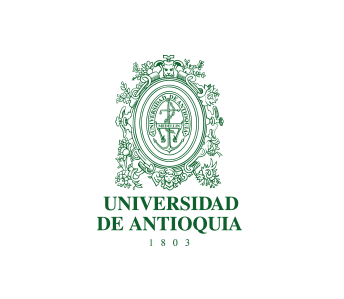

# Proyecto 1: Análisis de señales ECG y detección de arritmias

Estudiantes:
- Juan Camilo Carvajal Sierra - 1010124738
- Ana María Uribe Betancur - 1000537653
- Duvan Vega Cardona - 1003896233

In [ ]:
from scipy import stats
from scipy.stats import levene, shapiro, ttest_ind, mannwhitneyu
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# !pip install neurokit2
# !pip install -U gdown
# !pip install py-ecg-detectors

## Análisis 1: Exploración y selección de datos

Cargar  el  archivo  Diagnostics.xlsx  y  realizar  un  análisis  estadístico
general de los datos. Desde la información en la base de datos resolver
las siguientes preguntas.

In [ ]:
# file_id2 = '1IhCUZRzL8RkBqlRPpY5boBzukPkjOIqM'
# destination2 = 'Diagnostics.xlsx'

# !gdown --id {file_id2} --output {destination2}

In [ ]:
# # Se realiza la carga de archivos al entorno
# file_id = '1tGXh5G3DEOshn6DA28nioFCQv7ZX0e0l'
# destination = 'ECGDataDenoised.zip'

# !gdown --id {file_id} --output {destination}

In [ ]:
datos = pd.read_excel('Diagnostics.xlsx')
# Observación preliminar de las variables y estructura del dataset
datos.describe()

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
count,10646.000000,10646.000000,10646.00000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000,10646.000000
mean,59.186831,84.136107,92.57787,90.989292,384.150855,434.154048,39.620609,44.637704,13.839470,219.260567,264.755213,411.335995
std,18.030019,34.455349,60.09394,17.479540,59.226289,39.354182,41.212648,57.478092,5.676339,6.410413,8.362120,29.777404
min,4.000000,34.000000,0.00000,18.000000,114.000000,219.000000,-89.000000,-89.000000,5.000000,159.000000,249.000000,281.000000
25%,49.000000,57.000000,57.00000,80.000000,344.000000,408.000000,14.000000,19.000000,9.000000,216.000000,259.000000,392.000000
50%,62.000000,73.000000,72.00000,88.000000,390.000000,430.000000,46.000000,42.000000,12.000000,219.000000,264.000000,414.000000
75%,72.000000,104.000000,106.00000,98.000000,426.000000,456.000000,68.000000,62.000000,17.000000,224.000000,268.000000,432.000000
max,98.000000,263.000000,535.00000,256.000000,736.000000,760.000000,270.000000,270.000000,40.000000,240.000000,331.000000,582.000000


In [ ]:
# Verificfación de posibles datos nulos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646 entries, 0 to 10645
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FileName         10646 non-null  object
 1   Rhythm           10646 non-null  object
 2   Beat             10646 non-null  object
 3   PatientAge       10646 non-null  int64 
 4   Gender           10646 non-null  object
 5   VentricularRate  10646 non-null  int64 
 6   AtrialRate       10646 non-null  int64 
 7   QRSDuration      10646 non-null  int64 
 8   QTInterval       10646 non-null  int64 
 9   QTCorrected      10646 non-null  int64 
 10  RAxis            10646 non-null  int64 
 11  TAxis            10646 non-null  int64 
 12  QRSCount         10646 non-null  int64 
 13  QOnset           10646 non-null  int64 
 14  QOffset          10646 non-null  int64 
 15  TOffset          10646 non-null  int64 
dtypes: int64(12), object(4)
memory usage: 1.3+ MB


In [ ]:
# Conteo de arritmias y sus frecuencias
datos.groupby('Rhythm')["FileName"].count()

Rhythm
AF        445
AFIB     1780
AT        121
AVNRT      16
AVRT        8
SA        399
SAAWR       7
SB       3889
SR       1826
ST       1568
SVT       587
Name: FileName, dtype: int64

##### **¿Qué tipo de arritmias son más prevalentes?**

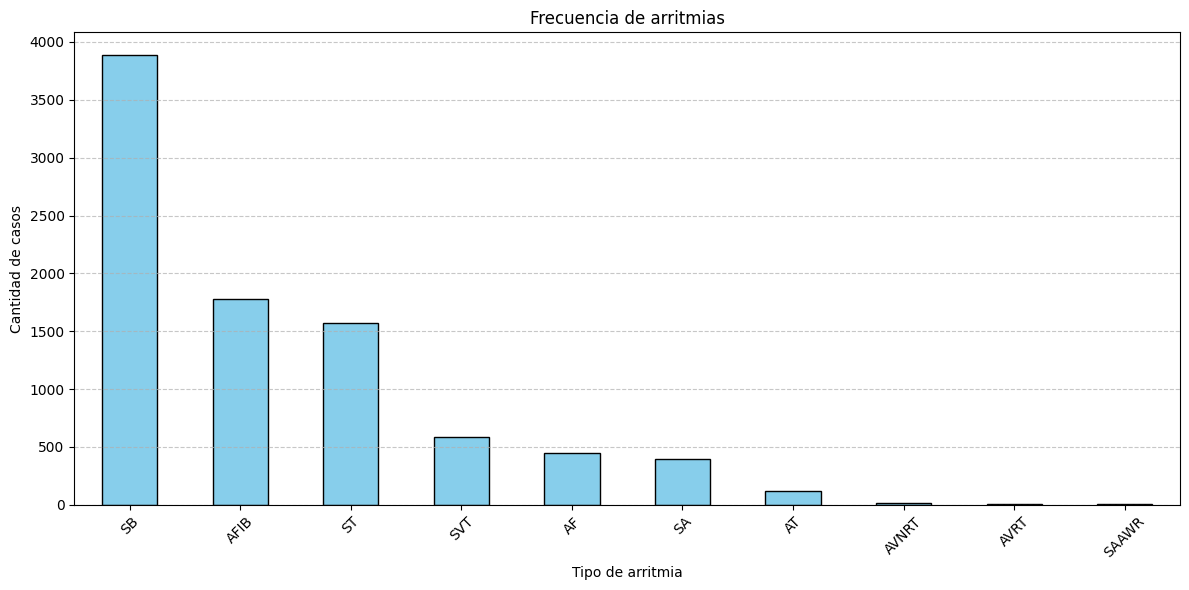

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pacientes con Sinus Bradycardia (SB): 3889 - 44.09%
Pacientes con Atrial Fibrillation (AFIB): 1780 - 20.18%
Pacientes con Sinus Tachycardia (ST): 1568 - 17.78%
Pacientes con Supraventricular Tachycardia (SVT): 587 - 6.66%
Pacientes con Atrial Flutter (AF): 445 - 5.05%
Pacientes con Sinus Arrhythmia (SA): 399 - 4.52%
Pacientes con Atrial Tachycardia (AT): 121 - 1.37%
Pacientes con Atrioventricular Nodal Reentrant Tachycardia (AVNRT): 16 - 0.18%
Pacientes con Atrioventricular Reentrant Tachycardia (AVRT): 8 - 0.09%
Pacientes con Sinus Arrhythmia with Atrial Wandering Rhythm (SAAWR): 7 - 0.08%


In [ ]:
# Filtrar los datos para eliminar el 'Sinus Rhythm' (SR)
datos_filtrados = datos[datos['Rhythm'] != 'SR']

conteo = datos_filtrados['Rhythm'].value_counts()

plt.figure(figsize=(12,6))
conteo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frecuencia de arritmias')
plt.xlabel('Tipo de arritmia')
plt.ylabel('Cantidad de casos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

conteo_lista = conteo.tolist()

patologias_str = [
    "Pacientes con Sinus Bradycardia (SB):",
    "Pacientes con Atrial Fibrillation (AFIB):",
    "Pacientes con Sinus Tachycardia (ST):",
    "Pacientes con Supraventricular Tachycardia (SVT):",
    "Pacientes con Atrial Flutter (AF):",
    "Pacientes con Sinus Arrhythmia (SA):",
    "Pacientes con Atrial Tachycardia (AT):",
    "Pacientes con Atrioventricular Nodal Reentrant Tachycardia (AVNRT):",
    "Pacientes con Atrioventricular Reentrant Tachycardia (AVRT):",
    "Pacientes con Sinus Arrhythmia with Atrial Wandering Rhythm (SAAWR):"
]

print('_ '*80)
for i in range(len(patologias_str)):
    porcentaje = (conteo_lista[i] / len(datos_filtrados)) * 100
    print(f'{patologias_str[i]} {conteo_lista[i]} - {porcentaje:.2f}%')

- De acuerdo con los datos recopilados anteriormente, la Bradicardia sinusal es la arritmia más prevalente dentro del estudio.

##### **¿Hay  arritmias  que  son  más  prevalentes  para  un  género específico?**

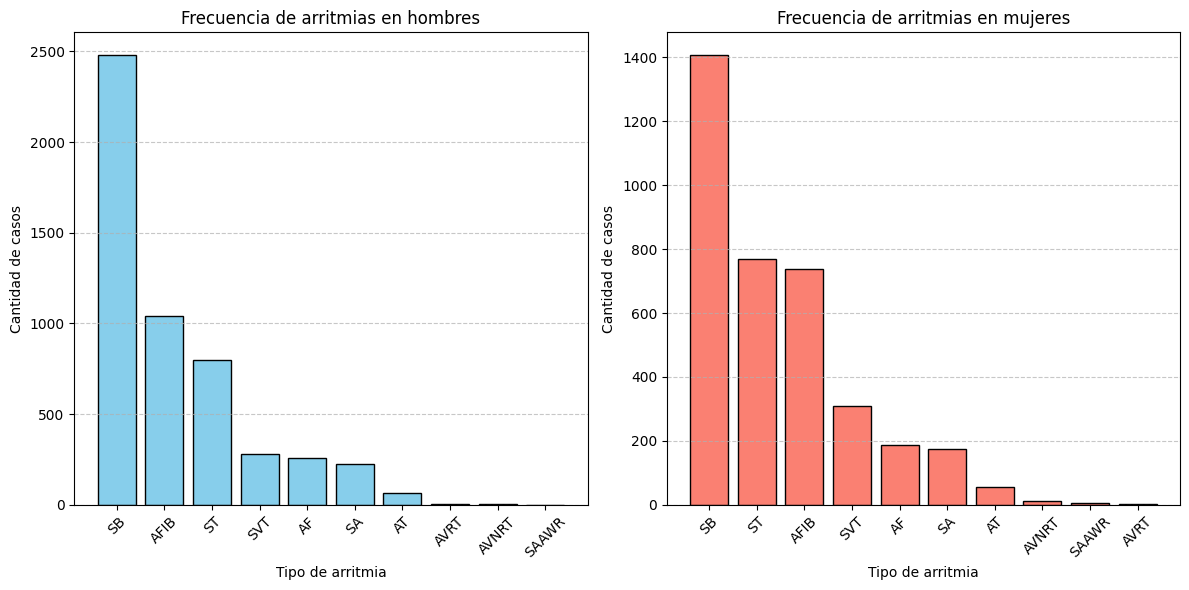

In [ ]:
# Filtrar los datos por género
hombres = datos_filtrados[datos_filtrados['Gender'] == 'MALE']
mujeres = datos_filtrados[datos_filtrados['Gender'] == 'FEMALE']

conteo_hombres = hombres['Rhythm'].value_counts()
conteo_mujeres = mujeres['Rhythm'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].bar(conteo_hombres.index, conteo_hombres.values, color='skyblue', edgecolor='black')
axs[0].set_title('Frecuencia de arritmias en hombres')
axs[0].set_xlabel('Tipo de arritmia')
axs[0].set_ylabel('Cantidad de casos')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].bar(conteo_mujeres.index, conteo_mujeres.values, color='salmon', edgecolor='black')
axs[1].set_title('Frecuencia de arritmias en mujeres')
axs[1].set_xlabel('Tipo de arritmia')
axs[1].set_ylabel('Cantidad de casos')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


- Se puede ver que en ambos géneros la arritmia más prevalecente es la Bradicardia Sinusal. Sin embargo se empiezan a ver diferencias en el resto de arritmias, ya que en las mujeres, la segunda arritmia más prevalencente es la taquicardia sinusal, mientras que en los hombres es la fibrilación auricular. Por lo que se corrobora que hay arritmias más prevalecentes para un género en específico.

##### **¿Hay arritmias que son más prevalentes para una edad?**

Para responder a esta pregunta, se dividieron los datos de la siguiente manera:
- 0 - 5 años: Niños pequeños
- 6 - 17 años: Adolescentes y preadolescentes
- 18 - 35 años: Jóvenes adultos
- 36 - 60 años: Adultos maduros
- $>$ 90 años: Ancianos longevos

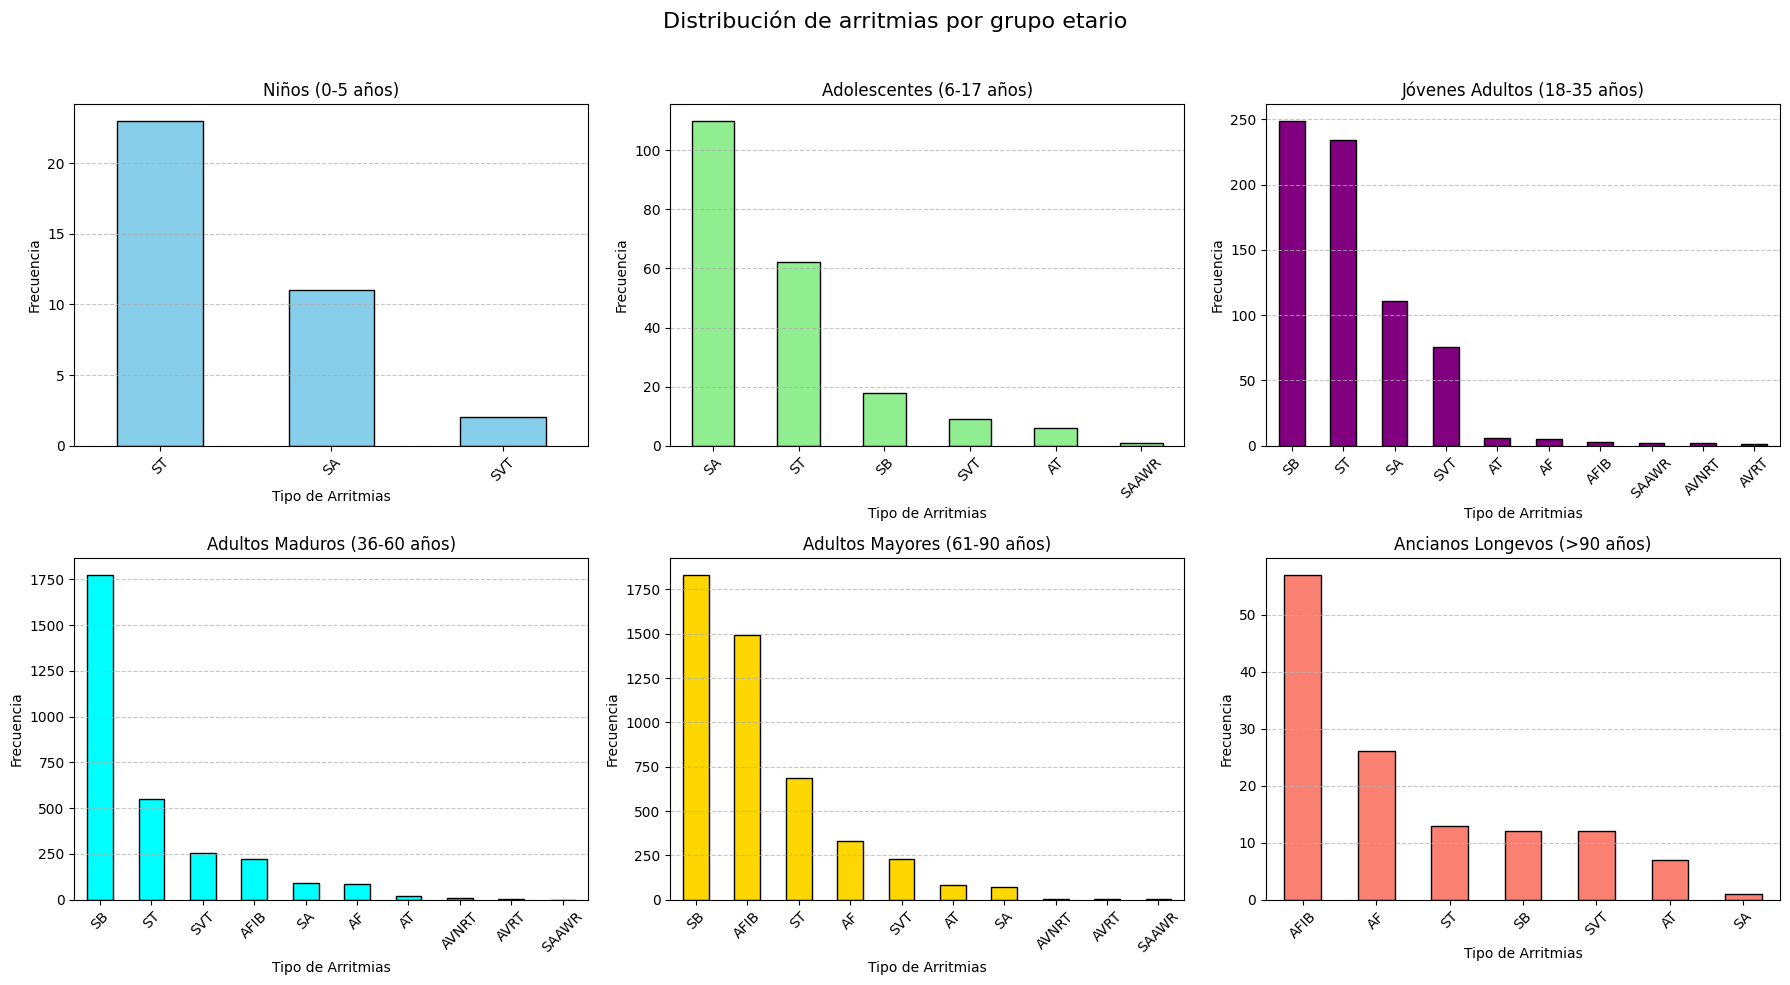

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Frecuencia del grupo etario respecto al total de casos:
Niños (0-5 años): 36 - 0.41%
Adolescentes (6-17 años): 206 - 2.34%
Jóvenes Adultos (18-35 años): 689 - 7.81%
Adultos Maduros (36-60 años): 3015 - 34.18%
Adultos Mayores (61-90 años): 4746 - 53.81%
Ancianos Longevos (>90 años): 128 - 1.45%


In [ ]:
# Filtrar los datos por edad (excluyendo SR)
niños = datos_filtrados[(datos_filtrados['PatientAge'] >= 0) & (datos_filtrados['PatientAge'] <= 5)]
adolescentes = datos_filtrados[(datos_filtrados['PatientAge'] >= 6) & (datos_filtrados['PatientAge'] <= 17)]
jóvenes_adultos = datos_filtrados[(datos_filtrados['PatientAge'] >= 18) & (datos_filtrados['PatientAge'] <= 35)]
adultos_maduros = datos_filtrados[(datos_filtrados['PatientAge'] >= 36) & (datos_filtrados['PatientAge'] <= 60)]
adultos_mayores = datos_filtrados[(datos_filtrados['PatientAge'] >= 61) & (datos_filtrados['PatientAge'] <= 90)]
ancianos_longevos = datos_filtrados[datos_filtrados['PatientAge'] > 90]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribución de arritmias por grupo etario', fontsize=16)

grupos = [
    (niños, 'Niños (0-5 años)', 'skyblue'),
    (adolescentes, 'Adolescentes (6-17 años)', 'lightgreen'),
    (jóvenes_adultos, 'Jóvenes Adultos (18-35 años)', 'purple'),
    (adultos_maduros, 'Adultos Maduros (36-60 años)', 'cyan'),
    (adultos_mayores, 'Adultos Mayores (61-90 años)', 'gold'),
    (ancianos_longevos, 'Ancianos Longevos (>90 años)', 'salmon')
]

for ax, (grupo, titulo, color) in zip(axs.flat, grupos):
    if not grupo.empty:
        grupo['Rhythm'].value_counts().plot(kind='bar', ax=ax, color=color, edgecolor='black')
        ax.set_title(titulo)
        ax.set_xlabel('Tipo de Arritmias')
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        ax.set_title(titulo)
        ax.text(0.5, 0.5, 'Sin datos', ha='center', va='center', fontsize=12)
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print('_ '*100)
print("Frecuencia del grupo etario respecto al total de casos:")
for grupo, df in [
    ("Niños (0-5 años)", niños),
    ("Adolescentes (6-17 años)", adolescentes),
    ("Jóvenes Adultos (18-35 años)", jóvenes_adultos),
    ("Adultos Maduros (36-60 años)", adultos_maduros),
    ("Adultos Mayores (61-90 años)", adultos_mayores),
    ("Ancianos Longevos (>90 años)", ancianos_longevos)]:
    porcentaje = (len(df) / len(datos_filtrados)) * 100
    print(f"{grupo}: {len(df)} - {porcentaje:.2f}%")


- De acuerdo a los datos recopilados se concluye que sí hay arritmias más prevalecentes en ciertas edades, y que los rangos dónde se presenta mayor diversidad de arritmias son entre los 18 y 35 años (Jóvenes Adultos), entre 36 y 60 años (Adultos Maduros), y entre 61 y 90 años (Adultos Mayores).

##### **Los algoritmos de aprendizaje se basan en usar la mayor cantidad de datos posibles que sean comparables, ¿Qué rango de edades y arritmias de la base de datos entregada considera que debe usar para entrenar algoritmos de aprendizaje?**

De acuerdo a lo observado anteriormente, los rangos de edad que aportan mayor cantidad de datos comparables sería desde los 18 años hasta los 90 años. Siendo los rangos 36-60 y 61-90 los más voluminosos. Por el lado de las arritmias, podemos descartar Pacientes con _Atrioventricular Nodal Reentrant Tachycardia (ANRT), Atrioventricular Reentrant Tachycardia (AVRT) y Sinus Arrhythmia with Atrial Wandering Rhythm (SAAWR)_, ya que son grupos extremadamente pequeños en comparación con el volumen de datos.

##### **¿Hay  coincidencia  entre  lo  encontrado  en  literatura  y  lo encontrado en la base de datos?**

- La **Bradicardia Sinusal** es un tipo de arritmia en la que el corazón late a un ritmo más bajo de lo normal, considerando que la frecuencia en reposo en adultos suele estar entre 60 y 100 latidos por minuto (lpm). Sin embargo, en algunos casos no se trata de un signo de enfermedad; por ejemplo, en deportistas, suele ser un indicador de un aumento del tono vagal. Por ello, tiene sentido que esta arritmia sea predominante en ciertos rangos de edad: en jóvenes, debido al aumento del tono vagal, y en personas mayores, por la disminución del ritmo cardíaco asociada al envejecimiento.

- La **Taquicardia Atrial** es un tipo de arritmia en la que el corazón late mucho más rápido de lo normal, en un rango de 100 a 250 latidos por minuto (lpm). Este tipo de arritmia es relativamente común y no siempre es peligrosa, pero puede ocurrir a cualquier edad. Sin embargo, para los pacientes en estudio, que deberían estar en reposo, no es algo regular. Además, su incidencia y la edad de las personas que sufren de esta arritmia son factores directamente proporcionales, lo que corrobora con la literatura, confirmando que estos datos son congruentes.

Fuentes:
- https://www.imss.gob.mx/sites/all/statics/guiasclinicas/569GRR.pdf
- https://www.mayoclinic.org/diseases-conditions/atrial-tachycardia/symptoms-causes/syc-20573298

##### **¿Qué otros análisis propone desde la base de datos?**

- Relación entre enfermedades previas y tipo de arritmia:
    - Al tener acceso a un historial clínico, sería posible identificar de mejor manera las arritmias, ya que muchas condiciones médicas están directamente relacionadas con el desempeño cardiovascular de un sujeto.

## Análisis 2: Selección herramienta de análisis

A continuación, se seleccionan dos arritmias y 20 registros de ECG de cada arritmia. Se tomaron la AFIB y la SB ya que, además de ser las más presentes dentro de la población, se manifiestan de manera contraria respecto a la frecuencia cardiaca, variable deducible a partir de los picos R. La fibrilación auricular, si  bien se cartacteriza por fluctuaciones en el intervalo RR, se evidencia a nivel general en un aumento de la frecuencia cardiaca. Por otro lado, la bradicardia se manifiesta en la disminución del ritmo cardiaco, es decir, el aumento de tiempo comprendido en el intervalo RR.

Se quiere entonces observar el comportamiento de las herramientas Neurokit2 y Detectors al analizar los comportamientos de estas arritmias.

Fuentes:
- https://pmc.ncbi.nlm.nih.gov/articles/PMC9352004/
- https://nhcps.com/lesson/acls-symptomatic-bradycardia/#:~:text=R%2DR%20intervals%20are%20regular%2C%20overall%20rhythm%20is%20regular.&text=The%20rate%20is%20less%20than,usually%20more%20than%2040%20bpm.&text=There%20is%20one%20P%20wave%20in%20front%20of%20every%20QRS.


In [ ]:
# # Se extraen los archivos en una carpeta dentro del entorno
# import zipfile
# zip_path = "ECGDataDenoised.zip"
# extract_to = "ecg_data"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

In [ ]:
# Se establecen funciones para el análisis de las señales y la evaluación de cada herramienta
import neurokit2 as nk
from ecgdetectors import Detectors
import seaborn as sns

def evaluar_detectors(metadata_path, data_path, ritmo1="AFIB", ritmo2="SVT", n=20):
    metadata = pd.read_excel(metadata_path)

    # Filtrar los registros deseados, verificando si existen registros antes de proceder
    files1 = metadata[metadata["Rhythm"] == ritmo1]["FileName"].head(n).tolist()
    files2 = metadata[metadata["Rhythm"] == ritmo2]["FileName"].head(n).tolist()

    if not files1 and not files2:
        print(f"No se encontraron registros para los ritmos {ritmo1} y {ritmo2}.")
        return pd.DataFrame()

    resultados = []

    # Inicializar detector py-ecg
    detectors = Detectors(sampling_frequency=500)

    # Función auxiliar para analizar un archivo
    def analizar_archivo(file_id, clase):
        try:
            path = os.path.join(data_path, file_id + ".csv")
            signal = pd.read_csv(path, header=None)
            signal = signal.iloc[:, 1]  # Fitra en la derivación específica deseada

            # NeuroKit2
            ecg_cleaned = nk.ecg_clean(signal, sampling_rate=500)
            _, rpeaks_nk = nk.ecg_peaks(ecg_cleaned, sampling_rate=500)
            r_nk = len(rpeaks_nk['ECG_R_Peaks'])

            # Py-ECG
            r_py = len(detectors.hamilton_detector(signal.to_numpy()))

            resultados.append({
                "File": file_id,
                "Arritmia": clase,
                "R_NeuroKit2": r_nk,
                "R_PyECG": r_py,
                "Dif. absoluta": abs(r_nk - r_py),
                "Dif. relativa (%)": 100 * abs(r_nk - r_py) / max(r_nk, 1)
            })
        except Exception as e:
            print(f"Error con {file_id}: {e}")

    for f in files1:
        analizar_archivo(f, ritmo1)
    for f in files2:
        analizar_archivo(f, ritmo2)

    df_resultados = pd.DataFrame(resultados)
    #df_resultados.to_csv("resultados.csv", index=False)
    print("Resultados para cada señal:")
    display(df_resultados)
    print('_ '*80)
    print("Resultados medios: \n")
    print(df_resultados.groupby("Arritmia")[["R_NeuroKit2", "R_PyECG", "Dif. absoluta", "Dif. relativa (%)"]].mean())

    df_plot = pd.melt(df_resultados, id_vars=["File", "Arritmia"],
                  value_vars=["R_NeuroKit2", "R_PyECG"],
                  var_name="Método", value_name="N° Picos R")
    print('_ '*80)
    print("Resultados gráficos por método: \n")
    arritmias = df_plot["Arritmia"].unique()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Comparación de picos R detectados por método y tipo de arritmia", fontsize=16)

    for i, ritmo in enumerate(arritmias):
       sns.boxplot(
            data=df_plot[df_plot["Arritmia"] == ritmo],
            x="Arritmia",
            y="N° Picos R",
            hue="Método",
            palette="Set2",
            ax=axes[i]
        )
       axes[i].set_title(f"{ritmo}")
       axes[i].set_xlabel("Tipo de arritmia")
       axes[i].set_ylabel("Cantidad de picos R" if i == 0 else "")
       axes[i].legend(title="Método")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return df_resultados

Resultados para cada señal:


,File,Arritmia,R_NeuroKit2,R_PyECG,Dif. absoluta,Dif. relativa (%)
0,MUSE_20180113_171327_27000,AFIB,19,19,0,0.000000
1,MUSE_20180114_075026_69000,AFIB,16,16,0,0.000000
2,MUSE_20180113_133901_16000,AFIB,12,13,1,8.333333
3,MUSE_20180116_123940_90000,AFIB,13,13,0,0.000000
4,MUSE_20180114_075003_61000,AFIB,14,15,1,7.142857
5,MUSE_20180114_073026_18000,AFIB,20,20,0,0.000000
6,MUSE_20180113_074740_85000,AFIB,14,15,1,7.142857
7,MUSE_20180114_132044_36000,AFIB,19,19,0,0.000000
8,MUSE_20180116_131337_59000,AFIB,15,16,1,6.666667
9,MUSE_20180113_183351_27000,AFIB,12,13,1,8.333333


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Resultados medios: 

          R_NeuroKit2  R_PyECG  Dif. absoluta  Dif. relativa (%)
Arritmia                                                        
AFIB            15.05    15.70           0.65           4.959686
SB               9.35    10.25           0.90          10.166667
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Resultados gráficos por método: 



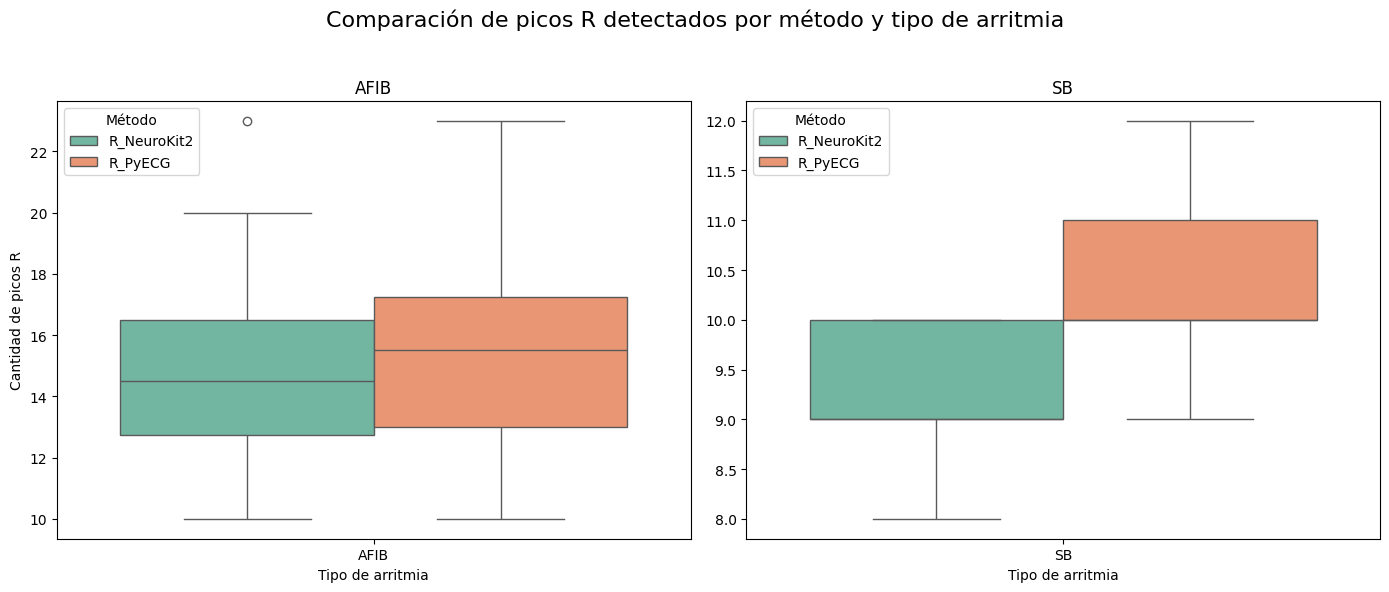

In [ ]:
# Se hace el llamado con las arritmias de interés
resultados = evaluar_detectors(
    metadata_path="Diagnostics.xlsx",
    data_path="ecg_data/ECGDataDenoised",
    ritmo1="AFIB",
    ritmo2="SB",
    n=20
)

 **¿Cuál de los algoritmos detecta mejor los picos R? Sustentar desde los
datos.**

Tanto para AFIB como para SB, la herramienta Detectors brindó mejores resultados en la detección de picos R, mostrando una precisión aumentada promedio de aproximadamente el 5% y 10%, respectivamente. Al visualizar los datos, puede notarse que siempre que hubo diferencias en la detección de picos, la sensibilidad óptima resultó ser de Detectors, evidenciando resultados más precisos independiente de la frecuencia de los picos.

De manera más específica, la herramienta mostró una mayor sensibilidad en los casos de SB, arrojando diferencias relativas de hasta el 37.5% respecto a Neurokit. Algoritmos como el de Hamilton son más robustos frente al ruido y a la variabilidad extrema del ritmo, lo que permite una detección más estable incluso en condiciones clínicas complejas.

De manera gráfica, la menor dispersión en los boxplots y las medianas más centradas sugieren que Py-ECG se adapta mejor a los datos evaluados, ofreciendo un rendimiento superior en la detección de picos R bajo condiciones arrítmicas.


**¿Qué otras rutinas incluyen las librerías que puedan ser de interés para
detectar diferencias en las arritmias (detección de otros picos o
segmentos relevantes).**

Neurokit:
- nk.ecg_delineate: Detecta segmentos clave del ECG, como picos P, QRS, T. Podría ser útil para determinar si hay ausencia de onda la P (como sucede comunmente en pacientes con AFIB), para análisis de morfología de la onda o para duración del complejo QRS (útil en SVT), y para comparar segmentos como PR, QT, y RR.
- nk.ecg_intervalrelated: Permite realizar los mismos análisis anteriores pero centrada en cada latido.

Py-ECG:
- Contiene variedad de algoritmos dedicados específicamente para la detección de picos R (como Hamilton, Christov, Pan-Tompkins, Engzee, Two average, Modified Pan-Tompkins), lo que podría resultar útil para probar su robustez dependiendo de la arritmia que se esté analizando.

Fuentes:
- https://neuropsychology.github.io/NeuroKit/introduction.html#physiological-data-analysis
- https://github.com/berndporr/py-ecg-detectors/blob/master/ecgdetectors.py




## Análisis 3: Variabilidad de la frecuencia cardíaca (HRV) y otros índices ECG

A continuación, se realiza el filtrado de los archivos según los parametros de edad y patología establecidos, y se analizan con Py-ECG-Detectors.
Se hizo una detección de picos R sobre todo el conjunto de datos y se calculó la variabilidad de la frecuencia cardíaca (HRV) a partir de los picos R detectados. Además, se hizo uso de la función *get_time_domain_features* para obtener parámetros asociados al HVR, además del SDNN y el RMSSD.

In [ ]:
# Se filtra el dataset según lo concluído en el Análisis 1
datos_2 = datos_filtrados[(datos_filtrados['PatientAge'] >= 18) & (datos_filtrados['PatientAge'] <= 90)]
datos_finales = datos_2[(datos_2['Rhythm'] != 'AVNRT') & (datos_2['Rhythm'] != 'AVRT') & (datos_2['Rhythm'] != 'SAAWR')]
datos_finales.describe()
datos_finales.to_csv("datos_finales.csv", index=False)

In [ ]:
datos_finales.groupby("Rhythm")["FileName"].count()

Rhythm
AF       419
AFIB    1723
AT       108
SA       277
SB      3859
ST      1470
SVT      564
Name: FileName, dtype: int64

***

In [ ]:
# !pip install hrv-analysis

In [ ]:
from hrvanalysis import get_time_domain_features
from tqdm import tqdm

In [ ]:
data_path = "ecg_data/ECGDataDenoised"  # Cambia si usas otra ruta
detectors = Detectors(sampling_frequency=500)

def detectar_r_pyecg(signal):
    return detectors.hamilton_detector(signal.to_numpy())

def calcular_nn_intervals(r_peaks, sampling_rate=500):
    return np.diff(r_peaks) * 1000 / sampling_rate # Para convertir a milisegundos

hrv_results = []
señales_descartadas = []

for _, row in tqdm(datos_finales.iterrows(), total=len(datos_finales), desc="Procesando ECGs"):
    archivo = f"{row['FileName']}.csv"
    file_path = os.path.join(data_path, archivo)

    if not os.path.exists(file_path):
        print(f"Archivo no encontrado: {archivo}")
        continue
    try:
        signal = pd.read_csv(file_path, header=None)
        signal = signal.iloc[:, 1]
        r_peaks = detectar_r_pyecg(signal)
        nn_intervals = calcular_nn_intervals(r_peaks)

        if len(nn_intervals) > 2:
            features = get_time_domain_features(nn_intervals.tolist())
            features["R_Peaks_Count"] = len(r_peaks)
            features["File"] = row["FileName"]
            features["Rhythm"] = row["Rhythm"]
            hrv_results.append(features)
        else:
          señales_descartadas.append((signal, row["FileName"]))
    except Exception as e:
        print(f"Error procesando {archivo}: {e}")

df_hrv = pd.DataFrame(hrv_results)
df_hrv.to_csv("Resultados_hrv.csv", index=False)

Procesando ECGs: 100%|██████████| 8420/8420 [03:30<00:00, 40.00it/s]


In [ ]:
df_hrv.head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,R_Peaks_Count,File,Rhythm
0,512.444444,62.382334,94.513140,12,70.588235,13,76.470588,94.636145,529.0,270.0,0.184676,0.121735,119.036973,173.410405,97.402597,16.796883,19,MUSE_20180113_171327_27000,AFIB
1,1097.250000,167.982780,146.443553,4,57.142857,6,85.714286,162.313629,1142.0,546.0,0.147928,0.153094,56.311562,86.206897,48.309179,11.442891,9,MUSE_20180112_073319_29000,SB
2,846.363636,176.369653,207.477131,8,80.000000,9,90.000000,213.942983,884.0,622.0,0.252779,0.208385,76.894843,173.410405,61.983471,30.840454,12,MUSE_20180111_165520_97000,SA
3,1036.888889,266.191869,258.181622,1,12.500000,2,25.000000,277.052342,1126.0,816.0,0.267196,0.256722,67.718712,182.926829,52.447552,40.736925,10,MUSE_20180113_121940_44000,SB
4,369.680000,26.861869,43.610651,4,16.666667,19,79.166667,43.642487,366.0,88.0,0.118055,0.072662,163.138247,182.926829,144.230769,11.770108,26,MUSE_20180112_122850_57000,AF


In [ ]:
df_hrv[df_hrv["Rhythm"] == "ST"].describe()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,R_Peaks_Count
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,546.103930,37.289712,50.513399,3.682313,23.143678,7.827891,48.713428,50.975842,544.192517,148.165986,0.091967,0.067327,111.789563,129.827532,97.956335,7.701603,18.195918
std,59.337986,33.085110,52.292112,3.076807,19.634552,4.349554,26.720893,52.479250,58.333041,109.860929,0.078948,0.050696,11.364666,24.637095,13.214341,6.396848,1.874478
min,341.285714,1.166055,1.648942,0.000000,0.000000,0.000000,0.000000,1.651446,342.000000,4.000000,0.003644,0.002825,36.586679,43.795620,30.181087,0.345188,6.000000
25%,518.491830,19.808588,26.824543,1.000000,6.666667,4.000000,26.666667,26.972760,516.000000,74.000000,0.051227,0.037131,103.717579,112.359551,90.090090,3.946744,17.000000
50%,556.588235,29.948706,40.770883,3.000000,18.750000,8.000000,50.000000,41.111897,556.000000,120.000000,0.075608,0.055934,108.789263,120.967742,97.087379,5.740521,18.000000
75%,580.625000,44.976843,58.102699,5.000000,33.333333,11.000000,70.588235,59.029369,580.000000,186.000000,0.106877,0.080678,116.596583,136.986301,104.166667,8.221863,19.000000
max,1654.000000,648.273742,1126.438548,19.000000,100.000000,19.000000,100.000000,1129.836173,1720.000000,1536.000000,1.170572,0.671647,175.861502,198.675497,174.418605,47.986889,29.000000


In [ ]:
df_hrv.groupby("Rhythm").count()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,R_Peaks_Count,File
Rhythm,,,,,,,,,,,,,,,,,,
AF,419,419,419,419,419,419,419,419,419,419,419,419,419,419,419,419,419,419
AFIB,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722,1722
AT,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108,108
SA,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277,277
SB,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859,3859
ST,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
SVT,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525,525


In [ ]:
f = df_hrv[df_hrv["Rhythm"] == "SB"]
np.shape(f["range_nni"])

(3859,)

Al observar las características del archivo obtenido, se evidencia que 40 archivos no pasaron el filtro del número mínimo de intervalos RR para hacer el análisis con *get_time_domain_features*. De estos 40, 1 corresponde a AFIB y 39 a SVT. Como ambas patologías se manifiestan en una alta frecuencia cardiaca, es decir, un mayor número de intervalos RR en el mismo tiempo, nació la duda sobre la veracidad del filtro y se graficaron las señales descartadas. Puede verse que eran señales nulas, exceptuando la primera, que Py-ECG falló en detectar. Se analizaron entonces 8380 señales en total.

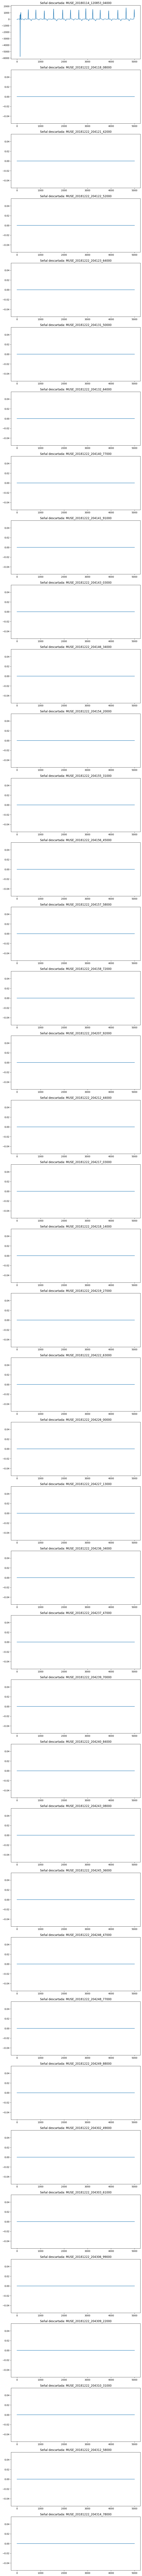

In [ ]:
num_signals_to_plot = 40
plt.figure(figsize=(10, 200))

for i in range(min(num_signals_to_plot, len(señales_descartadas))):
    signal, file_name = señales_descartadas[i]
    plt.subplot(num_signals_to_plot, 1, i+1)
    plt.plot(signal)
    plt.title(f"Señal descartada: {file_name}")


plt.show()

##### **Proponer análisis adicionales con las capacidades que ofrecen las librerías. Los análisis deben estar sustentados por la literatura y los datos que se están analizando.**

##### 1. Análisis en el dominio de la frecuencia

Función: **get_frequency_domain_features** de **hrvanalysis**
    
- Esta función calcula la potencia en las bandas LF (low frequency) y HF (high frequency), así como su relación LF/HF. Esta relación ha sido estudiada durante mucho tiempo, ya que se propone como un marcador del balance simpático-parasimpático del sistema nervioso autónomo. Aunque esta hipótesis no ha podido comprobarse de manera definitiva, es evidente que la relación LF/HF se ve afectada en presencia de arritmias, especialmente en casos de fibrilación auricular (AFIB), donde se ha demostrado una alteración directa de dicho balance. Por lo tanto, resulta valioso considerar esta herramienta en el análisis.

Fuentes:
- https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2014.00805/full
- https://www.ahajournals.org/doi/10.1161/circresaha.113.302549

##### 2. Análisis de entropía (regularidad del ritmo cardíaco)

Funciones:
    
**sample_entropy()** de **NeuroKit2**

**approximate_entropy()** de **NeuroKit2**

- La entropía es una medida matemática que indica cuán impredecible o cuán irregular es una señal. Para este contexto, lo que haces es medir qué tan impredecibles son los intervalos entre latidos (Picos RR), por lo que:
    - Si los latidos son muy regulares (por ejemplo, en reposo, sin alteraciones), la entropía es baja.
    - Si los latidos son muy irregulares (por ejemplo, en una fibrilación auricular), la entropía es alta.

Fuentes:
- https://repository.urosario.edu.co/server/api/core/bitstreams/37aeb667-969a-4c5c-9a36-67399f29d31a/content

## Análisis 4: Comparación de características entre grupos

A continuación, se comparan las diferentes arritmias mediante pruebas de hipótesis, utilizando como datos las métricas obtenidas previamente con la función get_time_domain_feature. Esta comparación se complementará con gráficos de estadística descriptiva.

Inicialmente, realizaremos una limpieza de características de HRV, ya que valores erróneos o faltantes pueden sesgar significativamente los resultados y llevar a conclusiones incorrectas.

In [ ]:
# Identificación y Conteo de Valores Faltantes e Infinitos ---

hrv_features_cols = df_hrv.select_dtypes(include=np.number).columns.tolist()
# Excluir columnas que no son características de HRV
cols_to_exclude = ['Rhythm', 'File']
for col in cols_to_exclude:
    if col in hrv_features_cols:
        hrv_features_cols.remove(col)

print("--- Identificación y Conteo Inicial de Valores Problemáticos ---")
print(f"Dimensiones iniciales del DataFrame: {df_hrv.shape}")
initial_rows_count = df_hrv.shape[0]

nan_counts = df_hrv[hrv_features_cols].isnull().sum()

# Conteo de Infinitos (inf, -inf) por columna de características HRV
# Usamos apply(pd.to_numeric, errors='coerce') para asegurarnos, aunque select_dtypes ya ayuda
df_numeric_hrv_subset = df_hrv[hrv_features_cols].apply(pd.to_numeric, errors='coerce')
inf_counts = df_numeric_hrv_subset.apply(lambda x: np.isinf(x).sum())

# Reporte inicial total de valores problemáticos encontrados
total_nan_hrv = nan_counts.sum()
total_inf_hrv = inf_counts.sum()
print(f"\nTotal de valores faltantes encontrados en columnas HRV: {total_nan_hrv}")
print(f"Total de valores Infinitos encontrados en columnas HRV: {total_inf_hrv}")
print("-" * 64)

--- Identificación y Conteo Inicial de Valores Problemáticos ---
Dimensiones iniciales del DataFrame: (8380, 19)

Total de valores faltantes encontrados en columnas HRV: 0
Total de valores Infinitos encontrados en columnas HRV: 0
----------------------------------------------------------------


Utilizaremos graficos de boxplot para analizar visualmente los datos atipicos en cada metrica.

C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

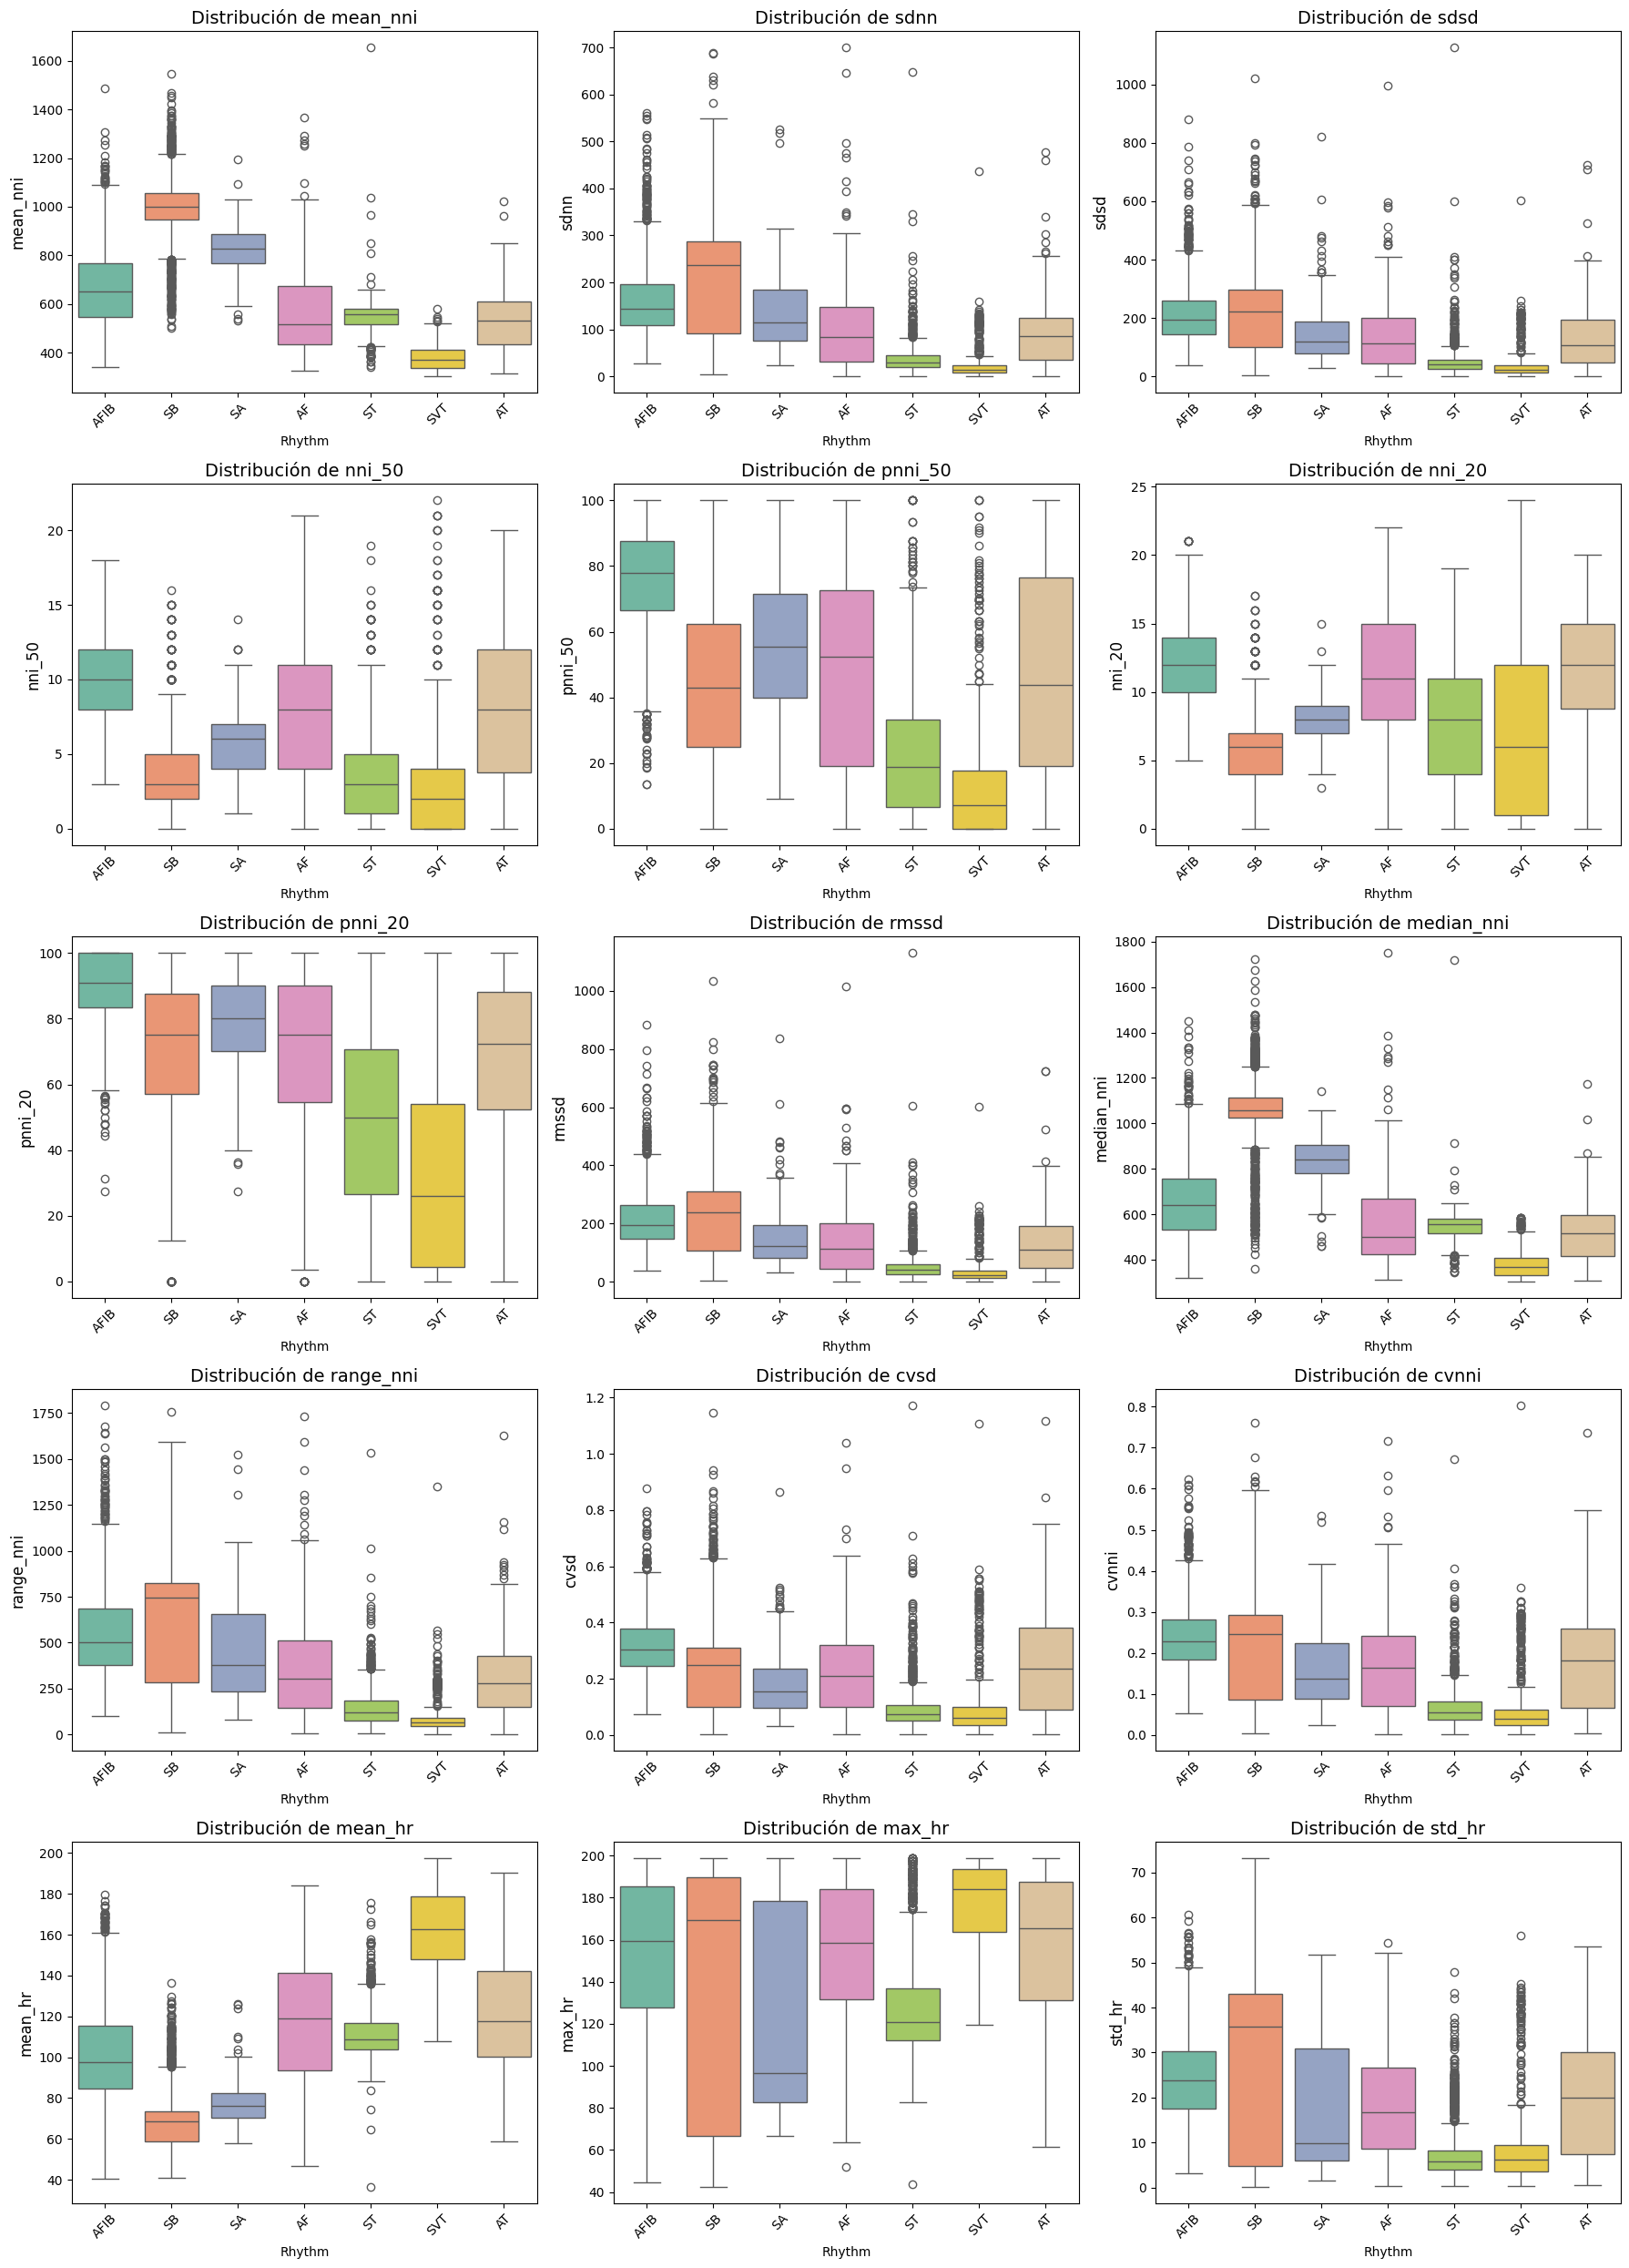

In [ ]:
def visualizar_boxplots_hrv(df_hrv, metricas):
    """
    Args:
    - df_hrv: DataFrame que contiene las métricas HRV y la columna 'Rhythm'.
    - metricas: Lista de nombres de las métricas a visualizar.
    """
    n_metricas = len(metricas)

    # Definir dimensiones de la figura
    filas = (n_metricas // 3) + int(n_metricas % 3 != 0)
    fig, axes = plt.subplots(filas, 3, figsize=(18, 5 * filas))
    axes = axes.flatten()

    # Crear un boxplot por métrica
    for idx, metrica in enumerate(metricas):
        ax = axes[idx]
        sns.boxplot(
            x="Rhythm",
            y=metrica,
            data=df_hrv,
            palette="Set2",
            ax=ax
        )
        ax.set_title(f"Distribución de {metrica}", fontsize=14)
        ax.set_ylabel(metrica, fontsize=12)
        ax.tick_params(axis='x', rotation=45)

    # Eliminar subplots vacíos si sobran
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

metricas_hrv = ["mean_nni", "sdnn", "sdsd", "nni_50", "pnni_50", "nni_20", "pnni_20",
                "rmssd", "median_nni", "range_nni", "cvsd", "cvnni", "mean_hr", "max_hr", "std_hr"]

visualizar_boxplots_hrv(df_hrv, metricas_hrv)


Dado que el propósito central de este análisis es diferenciar de manera precisa las distintas arritmias utilizando las métricas de Variabilidad de la Frecuencia Cardíaca (HRV), la calidad y representatividad de los datos son fundamentales.

En este contexto, los valores atípicos representan observaciones numéricamente muy distantes del patrón típico o central del conjunto de datos para cada métrica, siendo muy poco representativos del comportamiento general de los datos. La presencia de estos valores extremos tiene el potencial de distorsionar significativamente los resultados de los análisis estadísticos comparativos y, por ende, sesgar la capacidad de discriminar correctamente entre los diferentes grupos de arritmias basados en la HRV.

Por consiguiente, para garantizar la fiabilidad y robustez de la diferenciación entre arritmias, se tomó la determinación de identificar y eliminar estos valores atípicos en cada una de las métricas consideradas. Esta depuración se llevó a cabo bajo la estricta condición de que el volumen de datos remanente para cada métrica no se redujera por debajo del 95% del conjunto de datos original, asegurando así que la pérdida de información relevante fuera mínima y se preservara la integridad de la muestra en la mayor medida posible.

In [ ]:
def eliminar_outliers(df_hrv, metricas, columna_grupo='Rhythm', umbral_minimo=0.95):
    """
    Args:
    - df_hrv: DataFrame que contiene las métricas de HRV y la columna de agrupación (Rhythm).
    - metricas: Lista de métricas sobre las cuales eliminar outliers.
    - columna_grupo: Nombre de la columna que indica los grupos (default: 'Rhythm').
    - umbral_minimo: Proporción mínima de datos que deben permanecer (default: 0.95).

    """
    df_filtrado = df_hrv.copy()

    for metrica in metricas:
        datos_originales = len(df_filtrado)
        indices_a_eliminar = []

        for grupo in df_filtrado[columna_grupo].unique():
            datos_grupo = df_filtrado[df_filtrado[columna_grupo] == grupo][metrica]

            # Calcular IQR (rango intercuartílico)
            Q1 = datos_grupo.quantile(0.25)
            Q3 = datos_grupo.quantile(0.75)
            IQR = Q3 - Q1

            # Definir límites para outliers
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            # Indices que son outliers en este grupo
            indices_outliers = datos_grupo[(datos_grupo < limite_inferior) | (datos_grupo > limite_superior)].index.tolist()
            indices_a_eliminar.extend(indices_outliers)

        # Eliminar duplicados (en caso de que un índice aparezca en varios grupos)
        indices_a_eliminar = list(set(indices_a_eliminar))

        # Evaluar si la eliminación respeta el umbral
        datos_restantes = datos_originales - len(indices_a_eliminar)
        if datos_restantes / datos_originales >= umbral_minimo:
            df_filtrado = df_filtrado.drop(index=indices_a_eliminar)
        else:
            print(f"No se eliminaron outliers en '{metrica}' para respetar el 95% de los datos.")

    return df_filtrado

metricas_hrv = ["mean_nni", "sdnn", "sdsd", "nni_50", "pnni_50", "nni_20", "pnni_20",
                "rmssd", "median_nni", "range_nni", "cvsd", "cvnni", "mean_hr", "max_hr", "std_hr"]

df_hrv_filtrado = eliminar_outliers(df_hrv, metricas_hrv)

C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\423679009.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

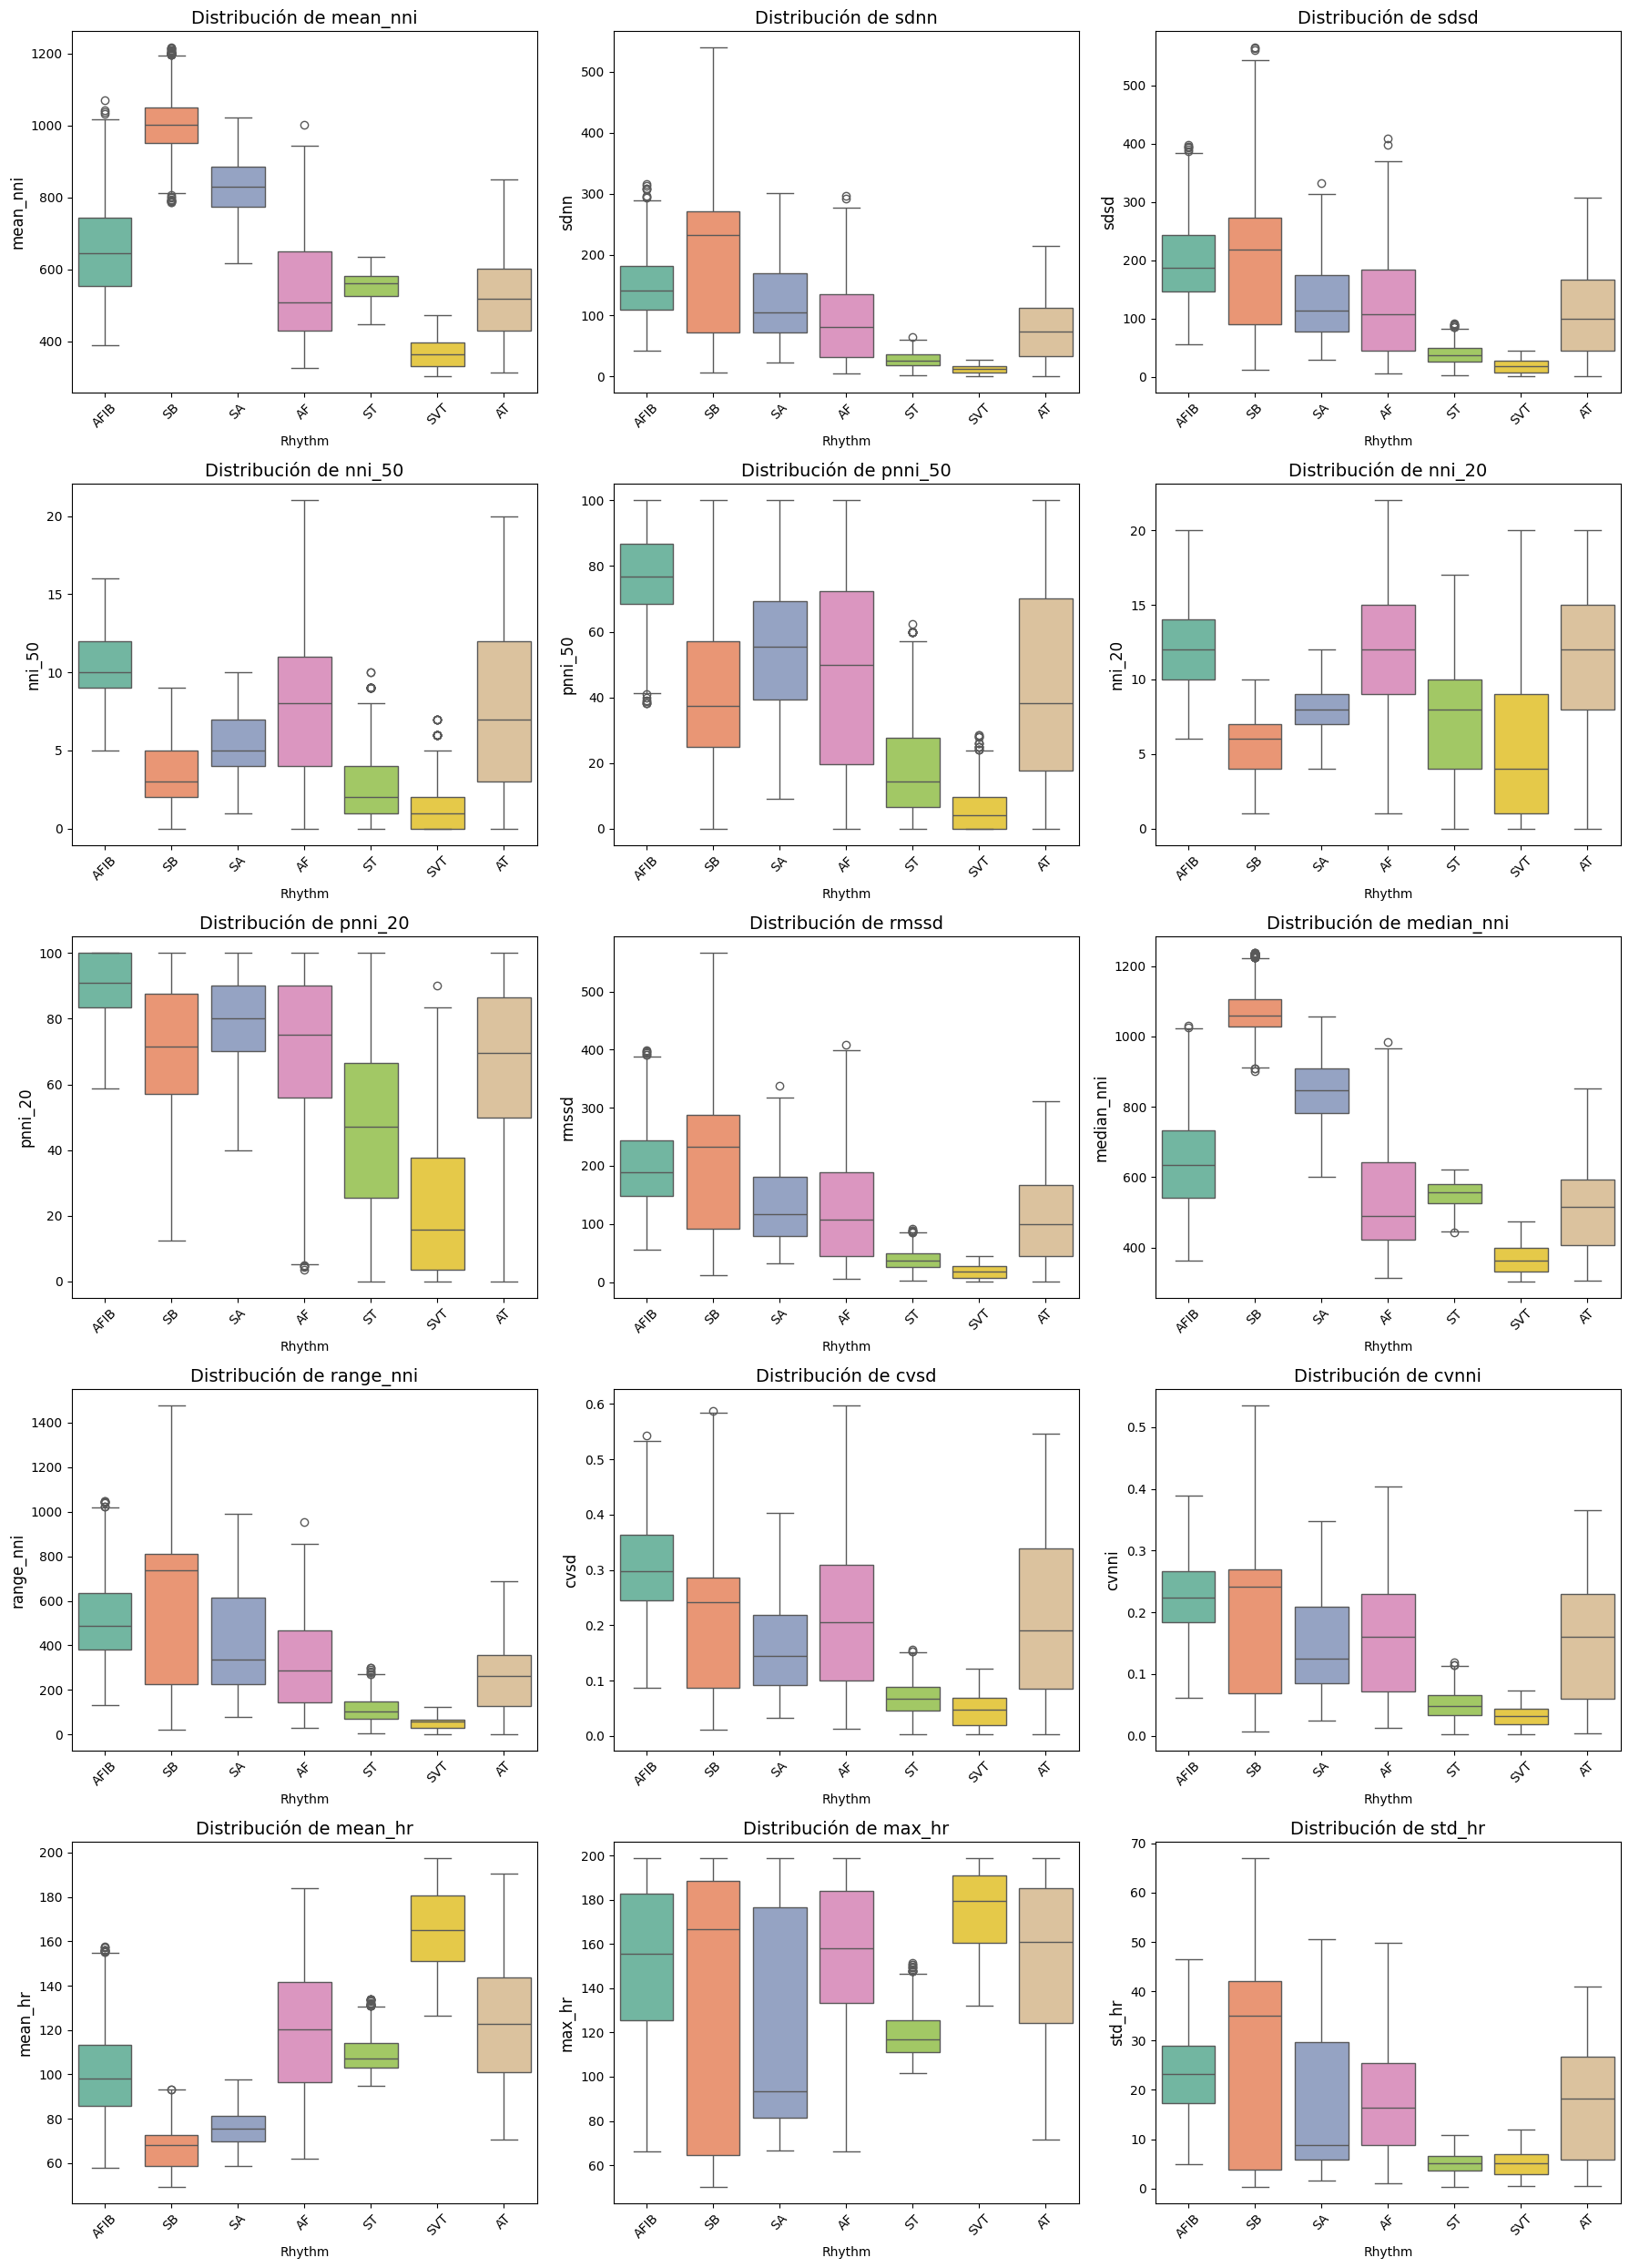

In [ ]:
visualizar_boxplots_hrv(df_hrv_filtrado, metricas_hrv)
df_hrv = df_hrv_filtrado

Ya con los datos depurados que puedan sergar las resultados de las pruebas estadisticas, realizaremos una comparación paso a paso de la métrica SDNN (Desviación estándar de todos los intervalos NN) entre los pacientes con fibrilación auricular (AFIB) y aquellos con bradicardia sinusal (SB). Para seleccionar la prueba apropiada para cada métrica, primero validaremos los supuestos de normalidad y homocedasticidad.

**1.** Prueba de Normalidad: **Shapiro-Wilk**

Hipótesis
* H₀ (Hipótesis nula): Los datos siguen una distribución normal
* H₁ (Hipótesis alternativa): Los datos no siguen una distribución normal

Se utilizó un nivel de significancia de α = 0.05:
* Si p-valor > α , no rechazamos H₀, lo que sugiere que los datos provienen de una distribución normal
* Si p-valor ≤ α, rechazamos H₀, lo que indica que los datos no siguen una distribución normal

In [ ]:
_, p_valor_ritmo1 =  stats.shapiro(df_hrv[df_hrv["Rhythm"] == "AFIB"]["sdnn"])
_, p_valor_ritmo2 =  stats.shapiro(df_hrv[df_hrv["Rhythm"] == "SB"]["sdnn"])

print("\nPrueba de normalidad (Shapiro-Wilk):")
print(f"sdnn de AFIB: p-value = {p_valor_ritmo1}")
print(f"sdnn de SB: p-value = {p_valor_ritmo2}")

if p_valor_ritmo1 > 0.05 and p_valor_ritmo2 > 0.05:
  print("\nDecisión: No rechazamos la hipótesis nula")
  print("Conclusión: SDNN de pacientes con AFIB y SB provienen de distribuciones normales.")
elif p_valor_ritmo1 <= 0.05 and p_valor_ritmo2 <= 0.05:
  print("\nDecisión: Rechazamos la hipótesis nula")
  print("Conclusión: SDNN de pacientes con AFIB y SB no provienen de distribuciones normales.")


Prueba de normalidad (Shapiro-Wilk):
sdnn de AFIB: p-value = 2.818864612588584e-16
sdnn de SB: p-value = 8.91043465379865e-42

Decisión: Rechazamos la hipótesis nula
Conclusión: SDNN de pacientes con AFIB y SB no provienen de distribuciones normales.


**2.** Prueba de Homocedasticidad: Levene
Hipótesis

  * H₀: Las varianzas de la metrica de los ECG son iguales (homocedasticidad)
  * H₁: Las varianza de la metrica de los ECG difieren (heterocedasticidad)

Se utilizó un nivel de significancia de α = 0.05:
  * Si p-valor > α, no rechazamos H₀, sugiriendo que las varianzas son iguales
  * Si p-valor ≤ α, rechazamos H₀, indicando que las varianzas difieren significativamente

In [ ]:
stat, p_valor_levene = stats.levene(df_hrv[df_hrv["Rhythm"] == "AFIB"]["sdnn"], df_hrv[df_hrv["Rhythm"] == "SB"]["sdnn"])
print(f"Prueba de Levene (Ciclo 1 vs Ciclo 5): p-value = {p_valor_levene}")
if p_valor_levene > 0.05:
  print("\nDecisión: No rechazamos la hipótesis nula")
  print("Conclusión: Las varianzas de SDNN de pacientes con AFIB y SB son iguales (homocedasticidad).")
else:
  print("\nDecisión: Rechazamos la hipótesis nula")
  print("Conclusión: Las varianzas de SDNN de pacientes con AFIB y SB difieren significativamente (heterocedasticidad).")

Prueba de Levene (Ciclo 1 vs Ciclo 5): p-value = 6.602192995868075e-105

Decisión: Rechazamos la hipótesis nula
Conclusión: Las varianzas de SDNN de pacientes con AFIB y SB difieren significativamente (heterocedasticidad).


Con base en los resultados de la validación de supuestos, se realizará la prueba t de Student o la prueba U de Mann-Whitney según corresponda.

In [ ]:
if p_valor_ritmo1 > 0.05 and p_valor_ritmo2 > 0.05 and p_valor_levene > 0.05:
  # Condiciones para prueba t satisfechas
  t_stat, p_value = stats.ttest_ind(df_hrv[df_hrv["Rhythm"] == "AFIB"]["sdnn"], df_hrv[df_hrv["Rhythm"] == "SB"]["sdnn"])
  print(f"Prueba t de SDNN(AFIB vs SB): t = {t_stat}, p-value = {p_value:.6f}")
  alpha = 0.05
  if p_value < alpha:
    print("Conclusión: Existe diferencia estadísticamente significativa entre la metrica SDNN de pacientes con AFIB y SB.")
  else:
    print("Conclusión: No existe diferencia estadísticamente significativa entre la metrica SDNN de pacientes con AFIB y SB.")
else:
  # Usamos prueba no paramétrica encaso de no cumplir las condiciones
  u_stat, p_value = stats.mannwhitneyu(df_hrv[df_hrv["Rhythm"] == "AFIB"]["sdnn"], df_hrv[df_hrv["Rhythm"] == "SB"]["sdnn"])
  print(f"Prueba U de Mann-Whitney de SDNN(AFIB vs SB): U = {u_stat}, p-value = {p_value}")
  alpha = 0.05
  if p_value < alpha:
    print("Conclusión: Existe diferencia estadísticamente significativa entre la metrica SDNN de pacientes con AFIB y SB.")
  else:
    print("Conclusión: No existe diferencia estadísticamente significativa entre la metrica SDNN de pacientes con AFIB y SB.")

Prueba U de Mann-Whitney de SDNN(AFIB vs SB): U = 1656399.0, p-value = 8.726352100450005e-74
Conclusión: Existe diferencia estadísticamente significativa entre la metrica SDNN de pacientes con AFIB y SB.


Este proceso se repite de manera idéntica con todas las métricas para comparar las diferentes patologías. A continuación, se presenta un resumen del tipo de prueba realizada para cada comparación, según los resultados de la validación de supuestos de normalidad y homocedasticidad.

C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\3869177521.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dummy_numeric = matriz_pruebas.replace({"t-test": 1, "Mann-Whitney": 0, "-": np.nan})
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\3869177521.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dummy_numeric = matriz_pruebas.replace({"t-test": 1, "Mann-Whitney": 0, "-": np.nan})
C:\Users\juanc\AppData\Local\Temp\ipykernel_2024\3869177521.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will

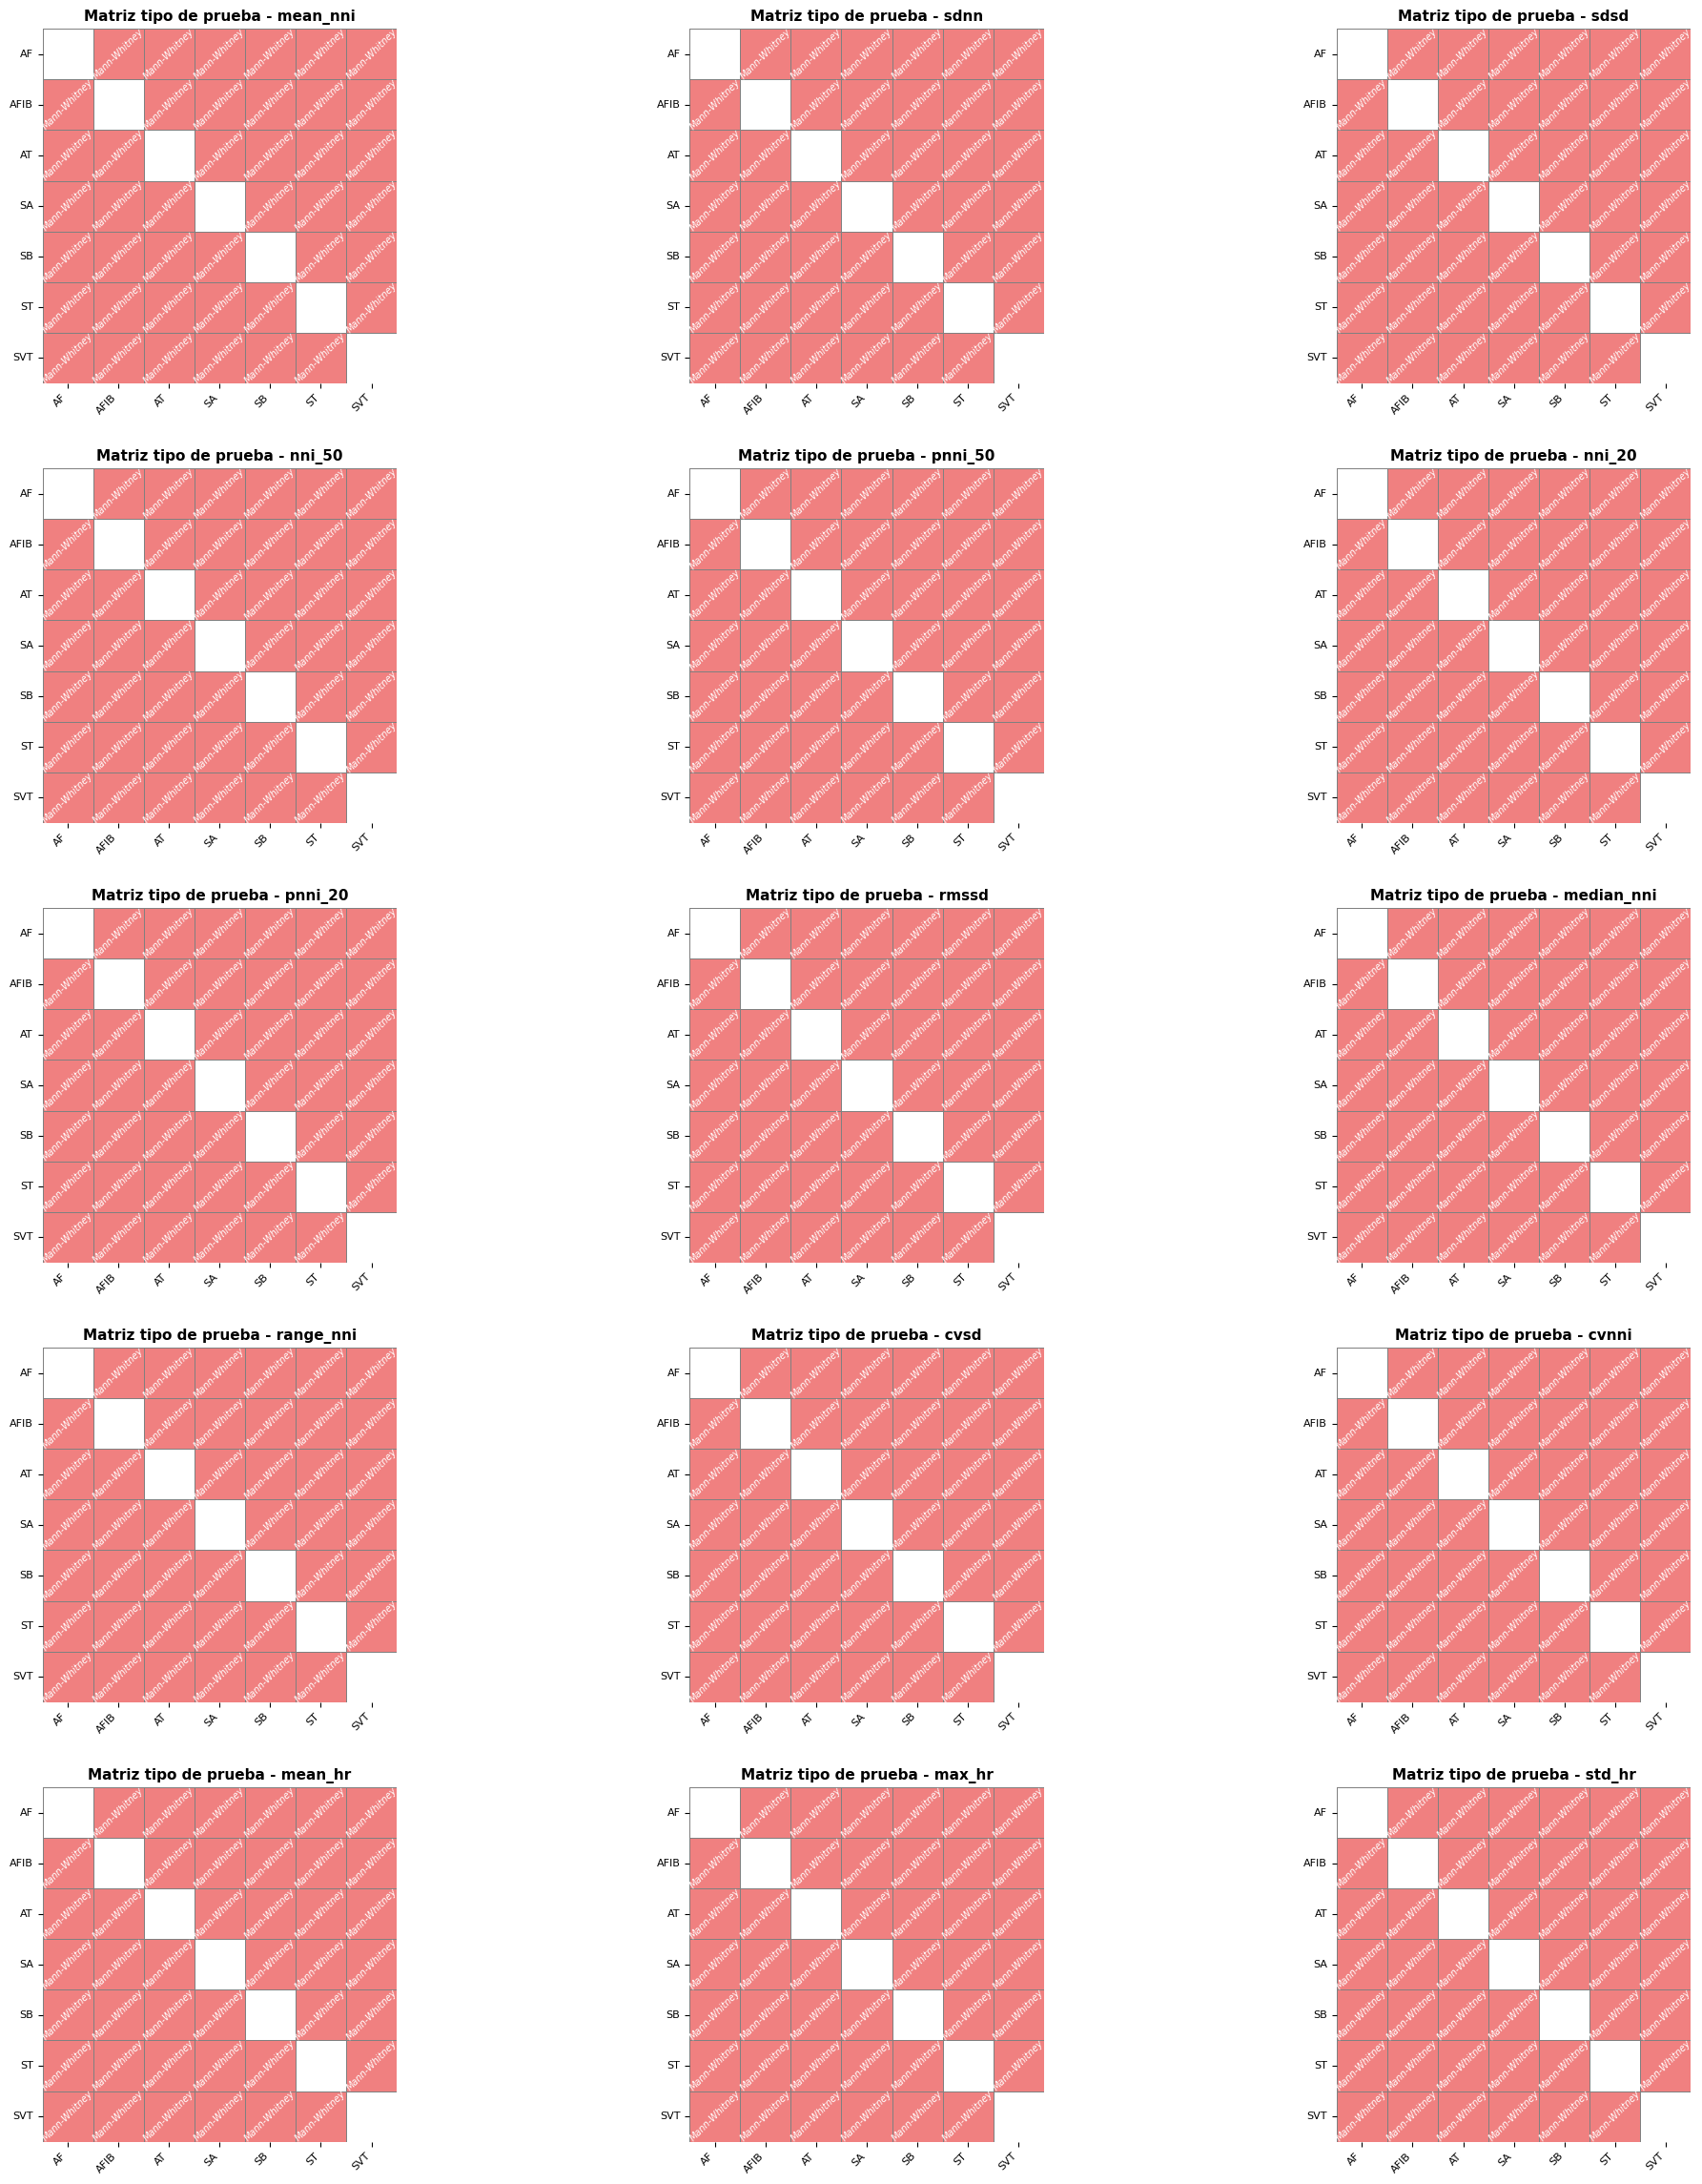

In [ ]:
def matriz_tipo_prueba_multiples_metricas(df_hrv, metricas):
    arritmias = df_hrv["Rhythm"].unique()
    arritmias.sort()

    fig, axes = plt.subplots(5, 3, figsize=(22,23))
    axes = axes.flatten()

    for idx, metrica in enumerate(metricas):
        matriz_pruebas = pd.DataFrame(index=arritmias, columns=arritmias, dtype=str)

        for ritmo1 in arritmias:
            for ritmo2 in arritmias:
                if ritmo1 == ritmo2:
                    matriz_pruebas.loc[ritmo1, ritmo2] = "-"
                else:
                    grupo1 = df_hrv[df_hrv["Rhythm"] == ritmo1][metrica]
                    grupo2 = df_hrv[df_hrv["Rhythm"] == ritmo2][metrica]

                    # Test de normalidad
                    _, p_normal1 = stats.shapiro(grupo1)
                    _, p_normal2 = stats.shapiro(grupo2)

                    normal = (p_normal1 > 0.05) and (p_normal2 > 0.05)

                    # Test de homocedasticidad
                    _, p_varianza = stats.levene(grupo1, grupo2)

                    varianzas_iguales = p_varianza > 0.05

                    if normal and varianzas_iguales:
                        prueba = "t-test"
                    else:
                        prueba = "Mann-Whitney"

                    matriz_pruebas.loc[ritmo1, ritmo2] = prueba

        # Para colorear: verde para t-test, rojo para Mann-Whitney
        color_mapping = {"t-test": "lightgreen", "Mann-Whitney": "lightcoral", "-": "white"}

        # Creamos matriz numérica dummy para seaborn heatmap
        dummy_numeric = matriz_pruebas.replace({"t-test": 1, "Mann-Whitney": 0, "-": np.nan})

        sns.heatmap(
            dummy_numeric.astype(float),
            annot=matriz_pruebas,
            fmt="",
            cmap=sns.color_palette(["lightcoral", "lightgreen"]),
            cbar=False,
            linewidths=0.6,
            linecolor="gray",
            ax=axes[idx],
            square=True,
            annot_kws={"size": 7, "rotation": 45, "fontstyle": "italic"}
        )

        axes[idx].set_title(f"Matriz tipo de prueba - {metrica}", fontsize=11, fontweight="bold")
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right', fontsize=8)
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0, fontsize=8)

    plt.tight_layout(h_pad=2.5, w_pad=1.5)  # Menor separación horizontal
    plt.show()

metricas_hrv = [
    "mean_nni", "sdnn", "sdsd", "nni_50", "pnni_50", "nni_20", "pnni_20",
    "rmssd", "median_nni", "range_nni", "cvsd", "cvnni", "mean_hr", "max_hr", "std_hr"
]

matriz_tipo_prueba_multiples_metricas(df_hrv, metricas_hrv)

Cada matriz se refiere a una métrica de comparación. La celda en la intersección de dos patologías indica el tipo de prueba estadística utilizada, determinado por los resultados de la validación de supuestos.
- Verde = Prueba t de Student (normalidad y homocedasticidad)
- Rojo = Prueba U de Mann-Whitney (algún supuesto no cumplido)
- — = Comparación no aplicable (misma arritmia)


La gráfica muestra que, independientemente de la métrica utilizada, la comparación entre las diferentes patologías siempre requiere la prueba U de Mann-Whitney. Esto se debe a que, como se esperaba, los supuestos [de normalidad y/o homocedasticidad] no se cumplen, algo común en datos fisiológicos de diferentes estados patológicos.

Por tanto, se aplicará la prueba U de Mann-Whitney a cada métrica para comparar los tipos de arritmias.

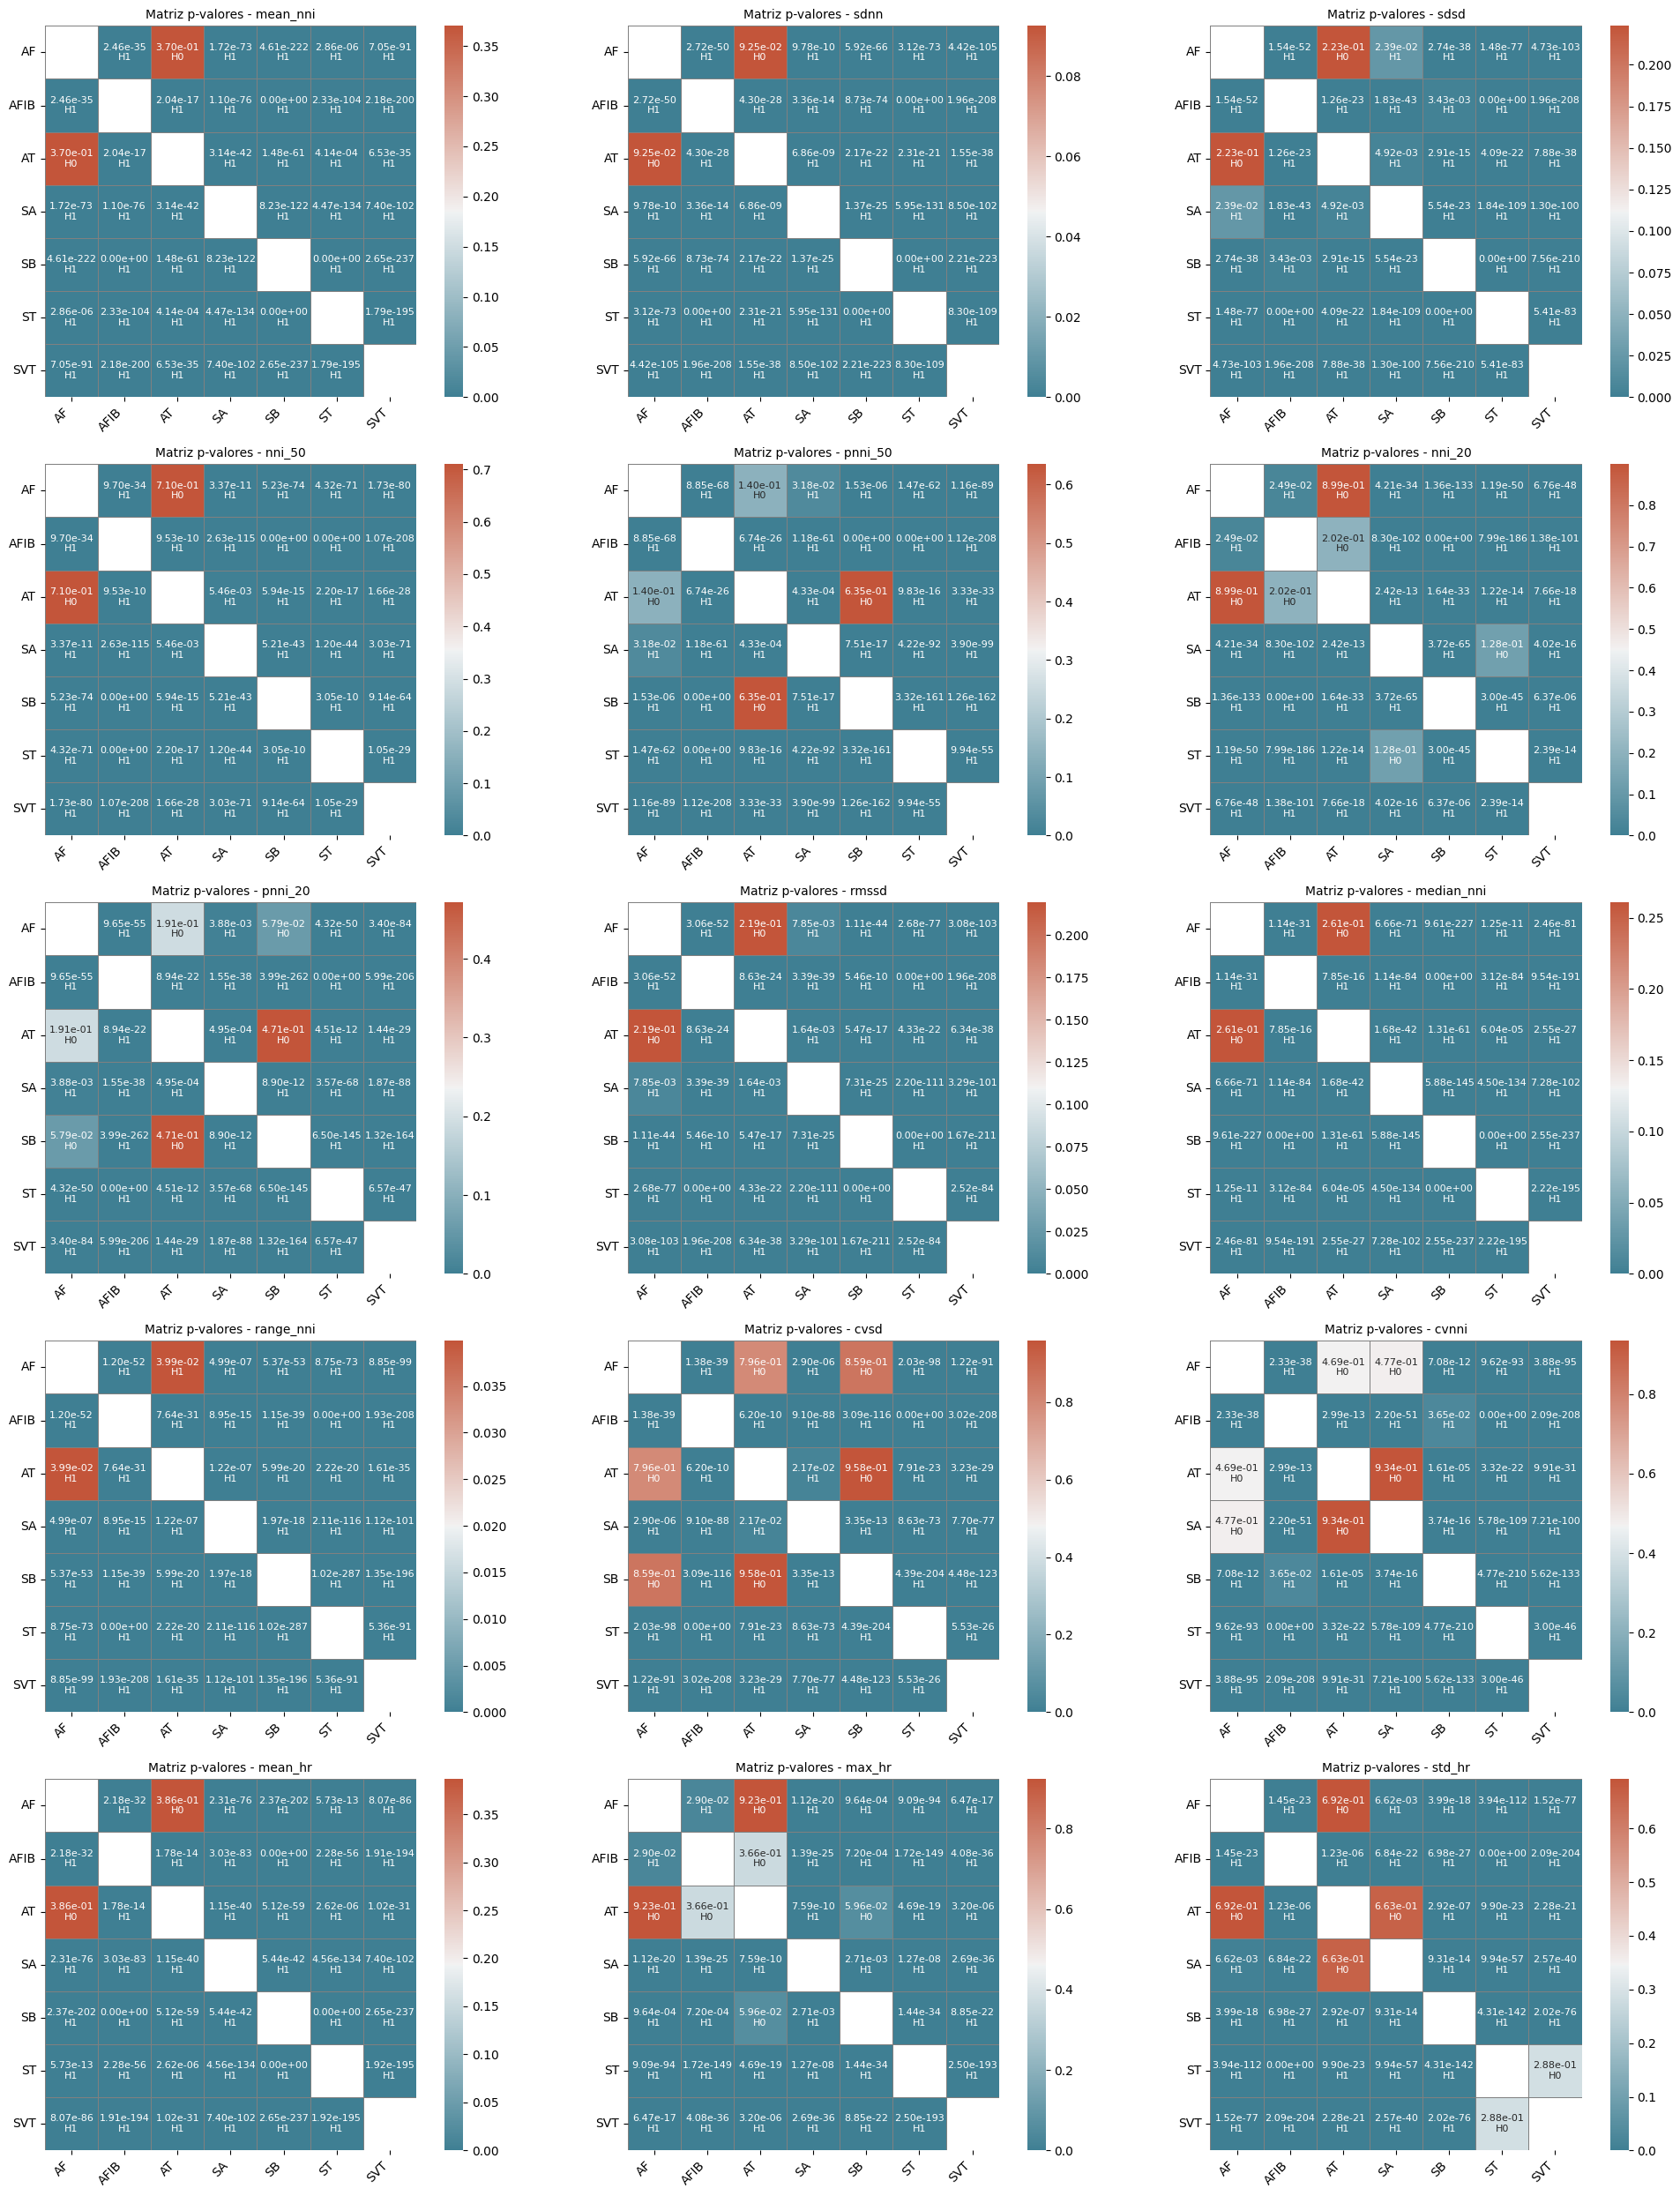

In [ ]:
def matriz_pvalores_multiples_metricas(df_hrv, metricas):
    arritmias = df_hrv["Rhythm"].unique()
    arritmias.sort()

    fig, axes = plt.subplots(5, 3, figsize=(20, 25))  # 5 filas, 3 columnas
    axes = axes.flatten()

    for idx, metrica in enumerate(metricas):
        matriz_pvalores = pd.DataFrame(index=arritmias, columns=arritmias, dtype=object)
        valores_p = []

        for ritmo1 in arritmias:
            for ritmo2 in arritmias:
                if ritmo1 == ritmo2:
                    matriz_pvalores.loc[ritmo1, ritmo2] = "-"
                else:
                    grupo1 = df_hrv[df_hrv["Rhythm"] == ritmo1][metrica]
                    grupo2 = df_hrv[df_hrv["Rhythm"] == ritmo2][metrica]
                    _, p_valor = stats.mannwhitneyu(grupo1, grupo2, alternative='two-sided')
                    valores_p.append(p_valor)
                    decision = "H1" if p_valor < 0.05 else "H0"
                    matriz_pvalores.loc[ritmo1, ritmo2] = f"{p_valor:.2e}\n{decision}"

        # Escala de colores basada en los valores p
        valores_p = np.array(valores_p)
        vmin = valores_p.min()
        vmax = valores_p.max()

        # Mapa de colores para el heatmap
        cmap = sns.diverging_palette(220, 20, as_cmap=True)

        # Creamos una versión numérica solo para heatmap
        matriz_numerica = matriz_pvalores.copy()
        for i in matriz_numerica.index:
            for j in matriz_numerica.columns:
                if matriz_numerica.loc[i, j] != "-":
                    matriz_numerica.loc[i, j] = float(matriz_pvalores.loc[i, j].split("\n")[0])
                else:
                    matriz_numerica.loc[i, j] = np.nan

        matriz_numerica = matriz_numerica.astype(float)

        # Heatmap
        sns.heatmap(
            matriz_numerica,
            annot=matriz_pvalores,
            fmt="",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            ax=axes[idx],
            cbar=True,
            square=True,
            linewidths=0.5,
            linecolor='gray',
            annot_kws={"size": 8}
        )

        axes[idx].set_title(f"Matriz p-valores - {metrica}", fontsize=10)
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0)

    # Ajustamos todo
    plt.tight_layout()
    plt.show()

metricas_hrv = [
    "mean_nni", "sdnn", "sdsd", "nni_50", "pnni_50", "nni_20", "pnni_20",
    "rmssd", "median_nni", "range_nni", "cvsd", "cvnni", "mean_hr", "max_hr", "std_hr"
]

matriz_pvalores_multiples_metricas(df_hrv, metricas_hrv)

En la anterior grafica se observa el valor-p obtenido al realizar la prueba U de Mann-Whitney junto con la hipotesis aceptada.
* H₀ (hipótesis nula): No hay diferencias en la mediana u orden general.
* H₁ (hipótesis alternativa): Una tiende a tener valores mayores o menores que la otra.

Finalmente, se resumen en una tabla los resultados de las pruebas para cada métrica.

In [ ]:
def resumen_comparaciones(df_hrv, metricas, alpha=0.05):
    resumen = []

    arritmias = df_hrv["Rhythm"].unique()
    arritmias.sort()

    for metrica in metricas:
        p_values = []
        p_values_rechazo = []
        aceptadas = 0
        rechazadas = 0
        total_comparaciones = 0

        for i, ritmo1 in enumerate(arritmias):
            for j, ritmo2 in enumerate(arritmias):
                if j <= i:
                    continue  # Evitar comparar dos veces o comparar contra sí mismo

                grupo1 = df_hrv[df_hrv["Rhythm"] == ritmo1][metrica]
                grupo2 = df_hrv[df_hrv["Rhythm"] == ritmo2][metrica]

                # Realizar prueba de Mann-Whitney
                _, p = mannwhitneyu(grupo1, grupo2, alternative="two-sided")
                p_values.append(p)

                if p < alpha:
                    rechazadas += 1
                    p_values_rechazo.append(p)
                else:
                    aceptadas += 1

                total_comparaciones += 1

        resumen.append({
            "Métrica": metrica,
            "N° de H₀ aceptadas": aceptadas,
            "% H₀ aceptadas": round((aceptadas/total_comparaciones)*100, 2),
            "N° de H₀ rechazadas": rechazadas,
            "% H₀ rechazada": round((rechazadas/total_comparaciones)*100, 2),
            "Promedio p-valor (todas)": "{:.2e}".format(np.mean(p_values)),
            "Promedio p-valor (rechazos)": "{:.2e}".format(np.mean(p_values_rechazo)) if p_values_rechazo else "-",
            "p-valor mínimo": "{:.2e}".format(np.min(np.array(p_values)[np.array(p_values) != np.float64(0.0)])),
            "p-valor máximo": "{:.2e}".format(np.max(p_values)),
        })

    df_resumen = pd.DataFrame(resumen)
    return df_resumen

metricas_hrv = [
    "mean_nni", "sdnn", "sdsd", "nni_50", "pnni_50", "nni_20", "pnni_20",
    "rmssd", "median_nni", "range_nni", "cvsd", "cvnni", "mean_hr", "max_hr", "std_hr"
]

df_resumen_resultados = resumen_comparaciones(df_hrv, metricas_hrv)

display(df_resumen_resultados)


,Métrica,N° de H₀ aceptadas,% H₀ aceptadas,N° de H₀ rechazadas,% H₀ rechazada,Promedio p-valor (todas),Promedio p-valor (rechazos),p-valor mínimo,p-valor máximo
0,mean_nni,1,4.76,20,95.24,1.76e-02,2.08e-05,2.65e-237,3.70e-01
1,sdnn,1,4.76,20,95.24,4.40e-03,3.92e-10,2.21e-223,9.25e-02
2,sdsd,1,4.76,20,95.24,1.22e-02,1.61e-03,7.56e-210,2.23e-01
3,nni_50,1,4.76,20,95.24,3.41e-02,2.73e-04,1.07e-208,7.10e-01
4,pnni_50,2,9.52,19,90.48,3.84e-02,1.70e-03,1.12e-208,6.35e-01
5,nni_20,3,14.29,18,85.71,5.97e-02,1.38e-03,7.99e-186,8.99e-01
6,pnni_20,3,14.29,18,85.71,3.45e-02,2.43e-04,3.99e-262,4.71e-01
7,rmssd,1,4.76,20,95.24,1.09e-02,4.75e-04,1.67e-211,2.19e-01
8,median_nni,1,4.76,20,95.24,1.24e-02,3.02e-06,2.55e-237,2.61e-01
9,range_nni,0,0.00,21,100.00,1.90e-03,1.90e-03,1.02e-287,3.99e-02


El análisis de los resultados obtenidos permite identificar a la métrica range_nni (rango de los intervalos NN) como aquella con la mayor capacidad discriminatoria entre los diferentes tipos de arritmias.

Esta conclusión se basa sólidamente en múltiples evidencias:

* Consistencia Absoluta: Range_nni fue la única métrica capaz de detectar diferencias significativas en el 100% de las comparaciones realizadas entre los distintos pares de arritmias. Esto significa que mostró diferencias estadísticamente significativas en todos los casos evaluados, una consistencia no igualada por ninguna otra métrica.
* Magnitud de las Diferencias (P-valores): Los valores p asociados a las comparaciones que involucran a range_nni fueron consistentemente y considerablemente más bajos que los de las demás métricas. Esto se reflejó en su p-valor global más bajo (1.02e-287) entre todas las métricas analizadas, un resultado que subraya la claridad y robustez de las diferencias que identifica.
* Promedio de p-valores significativamente Inferior: Reforzando esta conclusión, el valor promedio de los p-valores obtenidos para range_nni (1.90e-03) fue notablemente inferior a la media general del promedio de los p-valores de todas las métricas combinadas (2.43e-02). Esta diferencia sustancial en el promedio subraya aún más su excepcional capacidad para discriminar consistentemente entre los grupos.



---



Del mismo modo, para reforzar la elección de la metrica que logra mejor discriminación entre grupos se decide realizar prueba de Kruskal-Wallis; esta es un método estadístico no paramétrico diseñado para comparar tres o más grupos independientes y que, crucialmente, no exige que los datos sigan una distribución normal, característica fundamental para nuestro análisis, dado que las validaciones de supuestos previas (Shapiro-Wilk) confirmaron que la distribución de las métricas de HRV se desvía significativamente de la normalidad; por lo tanto, la aplicación de esta prueba nos permitirá identificar aquellas métricas que muestren diferencias estadísticamente significativas entre los grupos de arritmias, respaldando así su utilidad para la discriminación entre patologías.

Hipótesis

  * H₀: No hay diferencias significativas entre los grupos.
  * H₁: Hay diferencias entre los grupos.

Se utilizó un nivel de significancia de α = 0.05:
  * Si p-valor > α, no rechazamos H₀, sugiriendo que no hay evidencia suficiente para afirmar diferencias.
  * Si p-valor ≤ α, rechazamos H₀, indicando que hay evidencia de que los grupos son diferentes.

In [ ]:
from scipy.stats import kruskal

def prueba_kruskal_wallis(df_hrv, metricas, columna_grupo='Rhythm', alpha=0.05):
    """
    Args:
    - df_hrv: DataFrame que contiene las métricas y la columna de agrupación (Rhythm).
    - metricas: Lista de métricas de HRV.
    - columna_grupo: Nombre de la columna que indica los grupos (default: 'Rhythm').
    - alpha: Nivel de significancia para la prueba (default: 0.05).

    """
    resultados = []

    for metrica in metricas:
        # Agrupar los valores de la métrica por cada arritmia
        grupos = [grupo[metrica].dropna().values for nombre, grupo in df_hrv.groupby(columna_grupo)]

        # Aplicar la prueba de Kruskal-Wallis
        H, p_value = kruskal(*grupos)

        # Interpretar el resultado
        conclusion = 'H1: Hay diferencias' if p_value < alpha else 'H0: No hay diferencias'

        resultados.append({
            'Métrica': metrica,
            'Estadístico H': round(H, 4),
            'Valor p': float(f'{p_value}'),  # Notación científica
            'Conclusión': conclusion
        })

    resultados_df = pd.DataFrame(resultados)
    return resultados_df

metricas_hrv = ["mean_nni", "sdnn", "sdsd", "nni_50", "pnni_50", "nni_20", "pnni_20",
                "rmssd", "median_nni", "range_nni", "cvsd", "cvnni", "mean_hr", "max_hr", "std_hr"]

resultados_kruskal = prueba_kruskal_wallis(df_hrv, metricas_hrv)
display(resultados_kruskal)


,Métrica,Estadístico H,Valor p,Conclusión
0,mean_nni,5655.1196,0.000000e+00,H1: Hay diferencias
1,sdnn,3288.1752,0.000000e+00,H1: Hay diferencias
2,sdsd,3010.1850,0.000000e+00,H1: Hay diferencias
3,nni_50,3727.7123,0.000000e+00,H1: Hay diferencias
4,pnni_50,3485.7118,0.000000e+00,H1: Hay diferencias
5,nni_20,3266.5300,0.000000e+00,H1: Hay diferencias
6,pnni_20,2786.2159,0.000000e+00,H1: Hay diferencias
7,rmssd,3047.2269,0.000000e+00,H1: Hay diferencias
8,median_nni,5758.6614,0.000000e+00,H1: Hay diferencias
9,range_nni,2848.2348,0.000000e+00,H1: Hay diferencias


Como se observa en la tabla, la mayoría de los valores p obtenidos de la prueba de Kruskal-Wallis son representados como 0.00e+00 en notación científica.

Esta observación se explica por las diferencias muy pronunciadas detectadas entre los grupos de patologías respecto a la mayoría de las métricas de HRV. Tales diferencias resultan en estadísticos H de Kruskal-Wallis extremadamente grandes. Un valor H tan elevado produce un p-valor tan ínfimo que supera la precisión numérica estándar de los cálculos computacionales (comúnmente en implementaciones como la de scipy.stats en Python), siendo por ello mostrado como 0.00e+00, que es efectivamente un valor redondeado a cero.

Dado que estos resultados con p-valores < 0.05 indican claramente la existencia de diferencias estadísticamente significativas a nivel general entre al menos un par de los grupos de patologías, se confirma que las métricas analizadas son capaces de discriminar entre ellas.

Sin embargo, la prueba de Kruskal-Wallis no identifica cuáles pares específicos de grupos son diferentes entre sí. Por lo tanto, se hace necesario llevar a cabo pruebas post-hoc. Por consiguiente, se procederá a aplicar la prueba post-hoc de Dunn.

In [ ]:
# !pip install scikit_posthocs

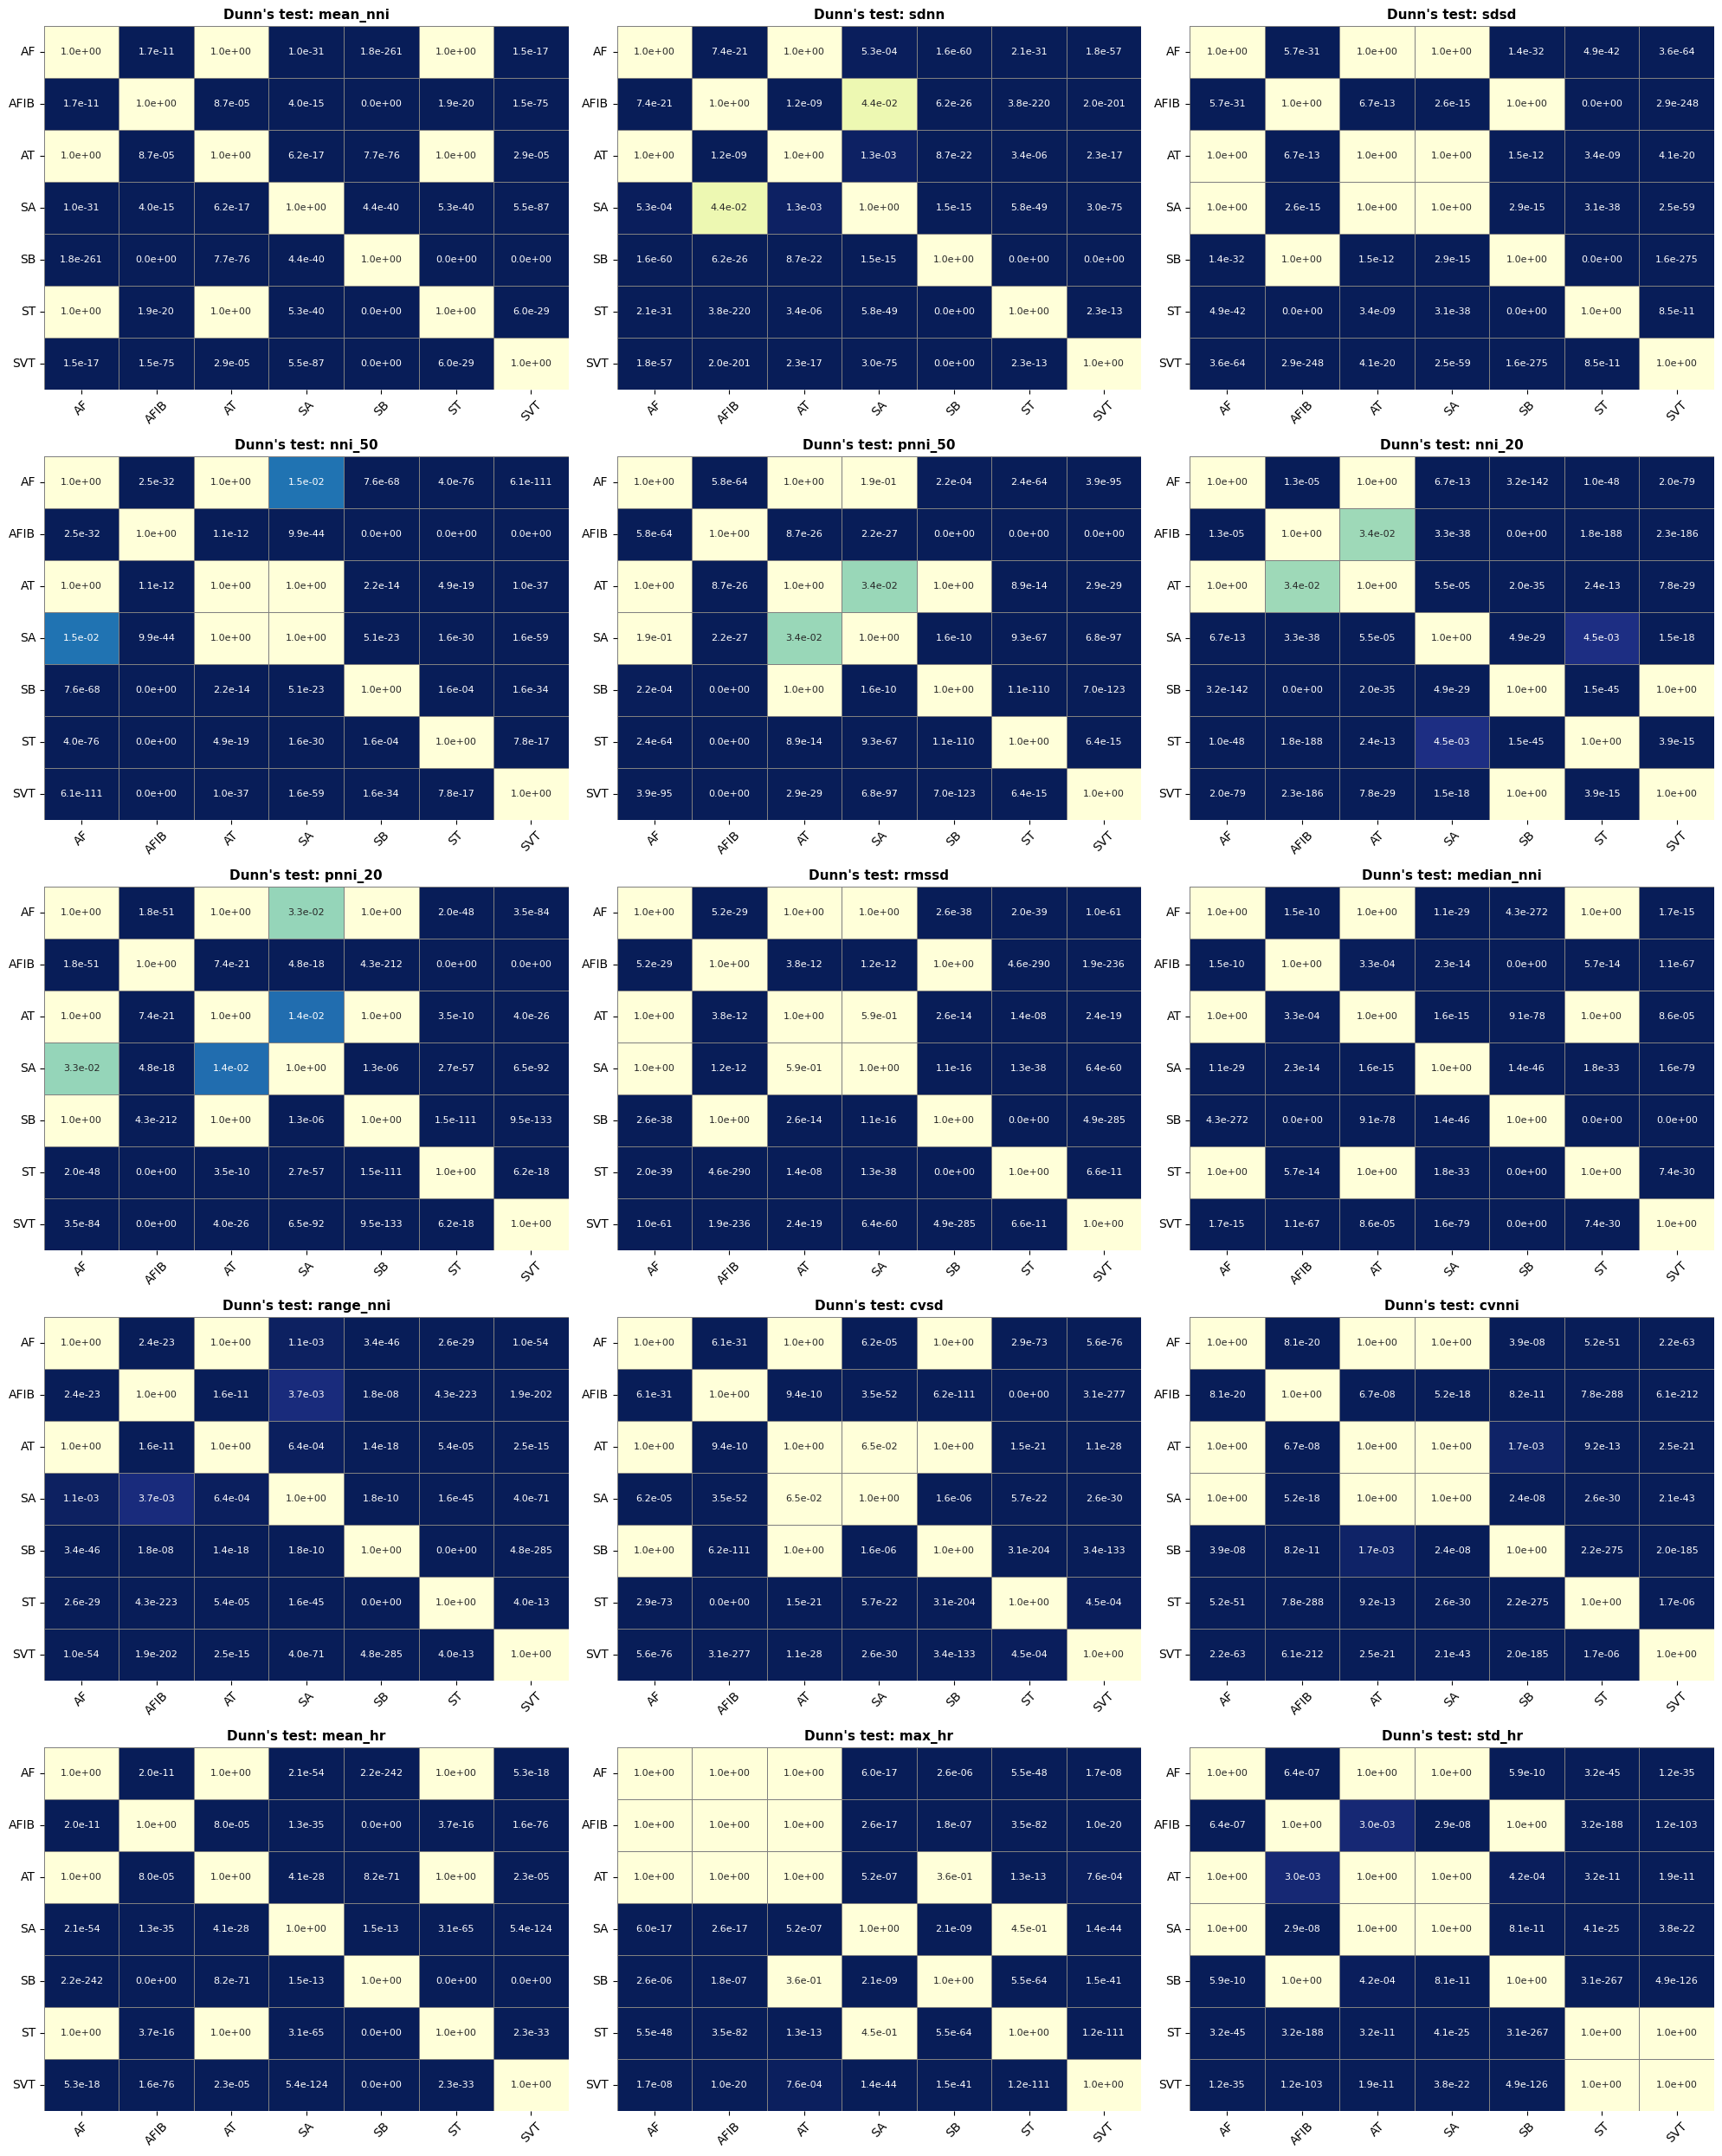

In [ ]:
from scipy.stats import kruskal
import scikit_posthocs as sp

def aplicar_dunn_posthoc_con_heatmap_grid_estetico(df, metricas_significativas, grupo_col='Rhythm', metodo_ajuste='bonferroni'):
    resultados_dunn = {}

    # Configurar la cuadrícula de plots
    filas, columnas = 5, 3
    fig, axes = plt.subplots(filas, columnas, figsize=(20, 25))
    axes = axes.flatten()

    # Definir límites para la escala de colores basada en los p-valores
    vmin = 0
    vmax = 0.05  # Como estamos interesados en diferencias significativas

    for idx, metrica in enumerate(metricas_significativas):
        if idx >= filas * columnas:
            print("Advertencia: hay más métricas que espacios disponibles en la cuadrícula.")
            break

        # Prepara los datos
        data = df[[grupo_col, metrica]].dropna()

        # Aplica Dunn's test
        dunn_result = sp.posthoc_dunn(
            data,
            val_col=metrica,
            group_col=grupo_col,
            p_adjust=metodo_ajuste
        )

        resultados_dunn[metrica] = dunn_result

        # Graficar con estilo bonito
        ax = axes[idx]
        sns.heatmap(
            dunn_result,
            annot=True,
            fmt=".1e",
            cmap="YlGnBu_r",
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            linewidths=0.5,
            linecolor='gray',
            ax=ax,
            annot_kws={"size":8}
        )
        ax.set_title(f"Dunn's test: {metrica}", fontsize=11, weight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Quitar los ejes vacíos sobrantes
    for j in range(idx+1, filas*columnas):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return resultados_dunn


# ---- USO DEL CÓDIGO ----

metricas_significativas = resultados_kruskal[resultados_kruskal['Valor p'] < 0.05]['Métrica'].tolist()

resultados_dunn = aplicar_dunn_posthoc_con_heatmap_grid_estetico(df_hrv, metricas_significativas)

In [ ]:
def resumen_dunn_test(dunn_test_results):
    """
    Crea una tabla de resumen numérico a partir de los resultados de Dunn's test.
    """
    resumen_data = {
        'Métrica': [],
        'Comparaciones Significativas (%)': [],
        'Promedio p': [],
        'Valor p mínimo': [],
        'Valor p máximo sig.': []
    }

    for metrica, df_pvalues in dunn_test_results.items():
        # Solo consideramos parte triangular inferior sin contar la diagonal (si aplica)
        pvalores = df_pvalues.where(np.tril(np.ones(df_pvalues.shape), k=-1).astype(bool))
        pvalores = pvalores.stack()  # convertir a Series

        total_comparaciones = len(pvalores)
        comparaciones_significativas = (pvalores < 0.05).sum()
        porcentaje_significativas = (comparaciones_significativas / total_comparaciones) * 100

        pvalores_significativos = pvalores[pvalores < 0.05]

        if len(pvalores_significativos) > 0:
            promedio_p_significativos = pvalores_significativos.mean()
            valor_p_minimo = pvalores.min()
            valor_p_maximo_significativo = pvalores_significativos.max()
        else:
            promedio_p_significativos = np.nan
            valor_p_minimo = pvalores.min()
            valor_p_maximo_significativo = np.nan

        resumen_data['Métrica'].append(metrica)
        resumen_data['Comparaciones Significativas (%)'].append(round(porcentaje_significativas, 2))
        resumen_data['Promedio p'].append(promedio_p_significativos)
        resumen_data['Valor p mínimo'].append(valor_p_minimo)
        resumen_data['Valor p máximo sig.'].append(valor_p_maximo_significativo)

    resumen_df = pd.DataFrame(resumen_data)
    resumen_df = resumen_df.sort_values(by='Comparaciones Significativas (%)', ascending=False).reset_index(drop=True)

    return resumen_df

resumen = resumen_dunn_test(resultados_dunn)
display(resumen)
print(resumen['Valor p mínimo'])

,Métrica,Comparaciones Significativas (%),Promedio p,Valor p mínimo,Valor p máximo sig.
0,sdnn,95.24,2.285103e-03,0.000000e+00,4.385342e-02
1,range_nni,95.24,2.762531e-04,0.000000e+00,3.727485e-03
2,nni_20,90.48,2.024727e-03,0.000000e+00,3.385603e-02
3,nni_50,90.48,8.099319e-04,0.000000e+00,1.523027e-02
4,pnni_50,85.71,1.874587e-03,0.000000e+00,3.352234e-02
5,pnni_20,85.71,2.642869e-03,0.000000e+00,3.312797e-02
6,mean_nni,85.71,6.437202e-06,0.000000e+00,8.733802e-05
7,mean_hr,85.71,5.736258e-06,0.000000e+00,8.012408e-05
8,median_nni,85.71,2.329702e-05,0.000000e+00,3.335145e-04
9,cvnni,85.71,9.182833e-05,7.758395e-288,1.651066e-03


0      0.000000e+00
1      0.000000e+00
2      0.000000e+00
3      0.000000e+00
4      0.000000e+00
5      0.000000e+00
6      0.000000e+00
7      0.000000e+00
8      0.000000e+00
9     7.758395e-288
10     0.000000e+00
11     0.000000e+00
12     0.000000e+00
13    1.158957e-111
14    3.053079e-267
Name: Valor p mínimo, dtype: float64
